# Regressão Linear 

Modelo de regressão linear usado como *baseline*

In [229]:
# importamos as libs
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np

sns.set_palette("Set2")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

## Fast Fourier Transform
from numpy.fft import rfft, irfft, rfftfreq, irfftn

## Funções e constantes

In [230]:
### Constantes que definimos

ANO_INICIAL = 1991
ANO_FINAL = 2019
ANO_BASE = 2017

PATH="/content/drive/MyDrive/TCC/data/csv/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

MAP = dict(zip(SIGLAS+[i for i in range(27)], [i for i in range(27)]+SIGLAS))

REGIAO = ['NORTE', 'NORDESTE', 'NORTE', 'NORTE', 'NORDESTE', 'NORDESTE',
  'CENTRO', 'SUDESTE', 'CENTRO', 'NORDESTE',
  'SUDESTE', 'CENTRO', 'CENTRO', 'NORTE', 'NORDESTE',
  'NORDESTE', 'NORDESTE', 'SUL', 'SUDESTE',
  'NORDESTE', 'NORTE', 'NORTE', 'SUL',
  'SUL', 'NORDESTE', 'SUDESTE', 'NORDESTE']

NORTE = [0,2,3,13,20,21]
NORDESTE = [1,4,5,9,14,15,16,19,24,26]
CENTRO = [6,8,11,12]
SUDESTE = [7,10,18,25]
SUL = [17,22,23]

In [231]:
# função que aplica a transformada de Fourier
def pass_ft(s, threshold=2e4):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-3 / s.size)
    fourier[frequencies > threshold] = 0

    return irfft(fourier,n=len(s))

In [232]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")


In [233]:
def show_predictions_graphs (y_pred, y_test):

    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)

        plt.title (f"Distribuição do erro do estado {MAP[state]}")

        pred = y_pred[state]
        real = y_test[state]

        plt.plot(pred, label="Previsão", color="coral")
        plt.plot(real, label="Dado Real", color="darkgreen")

        plt.legend()
    plt.show()

In [234]:
def split_y_state (y):

    if type(y) == np.ndarray:

        return dict(zip([i for i in range(27)], [[y[i] for i in range(s, len(y), 27)] for s in range(27)]))

    return dict(zip([i for i in range(27)], [[y.iloc[i] for i in range(s, y.size, 27)] for s in range(27)]))


In [235]:
def show_error_state(y_pred_state, y_test_state):

    plt.figure(figsize=(15,6))

    df = pd.DataFrame(SIGLAS, columns=["estados"])
    df["erro"] = [100*mean_absolute_percentage_error(y_test_state[i], y_pred_state[i]) for i in range(27)]

    sns.barplot(data=df, x="estados", y="erro", palette="Set2")
    plt.ylabel("MAPE por estado em %")

    plt.show()

In [236]:
def show_error_graphs (y_pred, y_test):

    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)

        plt.title (f"Distribuição de erro do estado {SIGLAS[state]}")

        pred = y_pred[state]
        real = y_test[state]

        error = [100*(round(mean_absolute_percentage_error([real[i]],[pred[i]]), 1)) for i in range(len(pred))]

        error = [i if i <= 100 else 100.0 for i in error]

        sns.countplot(error)
        plt.xlabel("Faixa de erro")
        plt.ylabel("Número de ocorrências")

    plt.show()

## Ler os dados

Aqui apenas lemos os dados do csv em `/data/csv/`


In [237]:
# input
x = pd.read_csv(PATH+"input.csv")

# target
y = pd.read_csv(PATH + "target_ac.csv")

In [238]:
x.head()

estados    data        pib_pc     pib_pmc  pib_pcpt   populacao  \
0      AC  199101  3.281564e+06   14.663360  0.708721    417102.0   
1      AL  199101  1.419695e+07   74.802077  0.510378   2512658.0   
2      AM  199101  1.481369e+07  192.541724  0.634686   2102766.0   
3      AP  199101  2.553397e+06   17.042118  0.793464    289035.0   
4      BA  199101  6.417557e+07  475.734256  0.488841  11867336.0   

         pib_cc  ipca  incc    igp     selic  idh_long  idh_renda  \
0  1.869529e+05  6.62   4.7  19.93  2.375185     0.645      0.647   
1  1.045711e+06  6.62   4.7  19.93  2.375185     0.552      0.574   
2  1.727997e+06  6.62   4.7  19.93  2.375185     0.668      0.527   
3  7.302087e+04  6.62   4.7  19.93  2.375185     0.645      0.620   
4  6.191147e+06  6.62   4.7  19.93  2.375185     0.582      0.605   

   idh_educacao   nfsp       estoque  desemprego  
0         0.176  11.17  4.782147e+06    9.216314  
1         0.174  11.17  4.782147e+06    8.980849  
2         0.254  11.17  4.782147e+06   11.555730  
3         0.204  11.17  4.782147e+06    5.922940  
4         0.182  11.17  4.782147e+06    8.211435

In [239]:
y.head()

data estados    consumo
0  199101      AC    16951.0
1  199102      AL   308951.0
2  199103      AM   259396.0
3  199104      AP    25699.0
4  199105      BA  1166517.0

# Modelo único para todos os estados

Para esse experimentos, vamos testar um modelo único para todos os estados do Brasil, adicionando aos dados um identificador para o estado.

Vamos utilizar One Hot Encoding para indicar o estado, esse método transforma uma variável categórica em colunas binárias para manter a informação necessária mas com um melhor desempenho que o Label Encoding

## Sem normalizar os dados

In [240]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")['consumo']

In [241]:
# aqui podemos observar as colunas geradas pelo método do one hot encoding
x.head()

pib_pc     pib_pmc  pib_pcpt   populacao        pib_cc  ipca  incc  \
0  3.281564e+06   14.663360  0.708721    417102.0  1.869529e+05  6.62   4.7   
1  1.419695e+07   74.802077  0.510378   2512658.0  1.045711e+06  6.62   4.7   
2  1.481369e+07  192.541724  0.634686   2102766.0  1.727997e+06  6.62   4.7   
3  2.553397e+06   17.042118  0.793464    289035.0  7.302087e+04  6.62   4.7   
4  6.417557e+07  475.734256  0.488841  11867336.0  6.191147e+06  6.62   4.7   

     igp     selic  idh_long  ...  estados_PR  estados_RJ  estados_RN  \
0  19.93  2.375185     0.645  ...           0           0           0   
1  19.93  2.375185     0.552  ...           0           0           0   
2  19.93  2.375185     0.668  ...           0           0           0   
3  19.93  2.375185     0.645  ...           0           0           0   
4  19.93  2.375185     0.582  ...           0           0           0   

   estados_RO  estados_RR  estados_RS  estados_SC  estados_SE  estados_SP  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   estados_TO  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 41 columns]

In [242]:
# shuffle = False para os dados continuarem em ordem 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.8633707870649363


In [243]:
# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 821444.8727562766
MAE: 562083.2719839852
MAPE: 0.8010375611125115


In [244]:
y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)

#### Gráficos

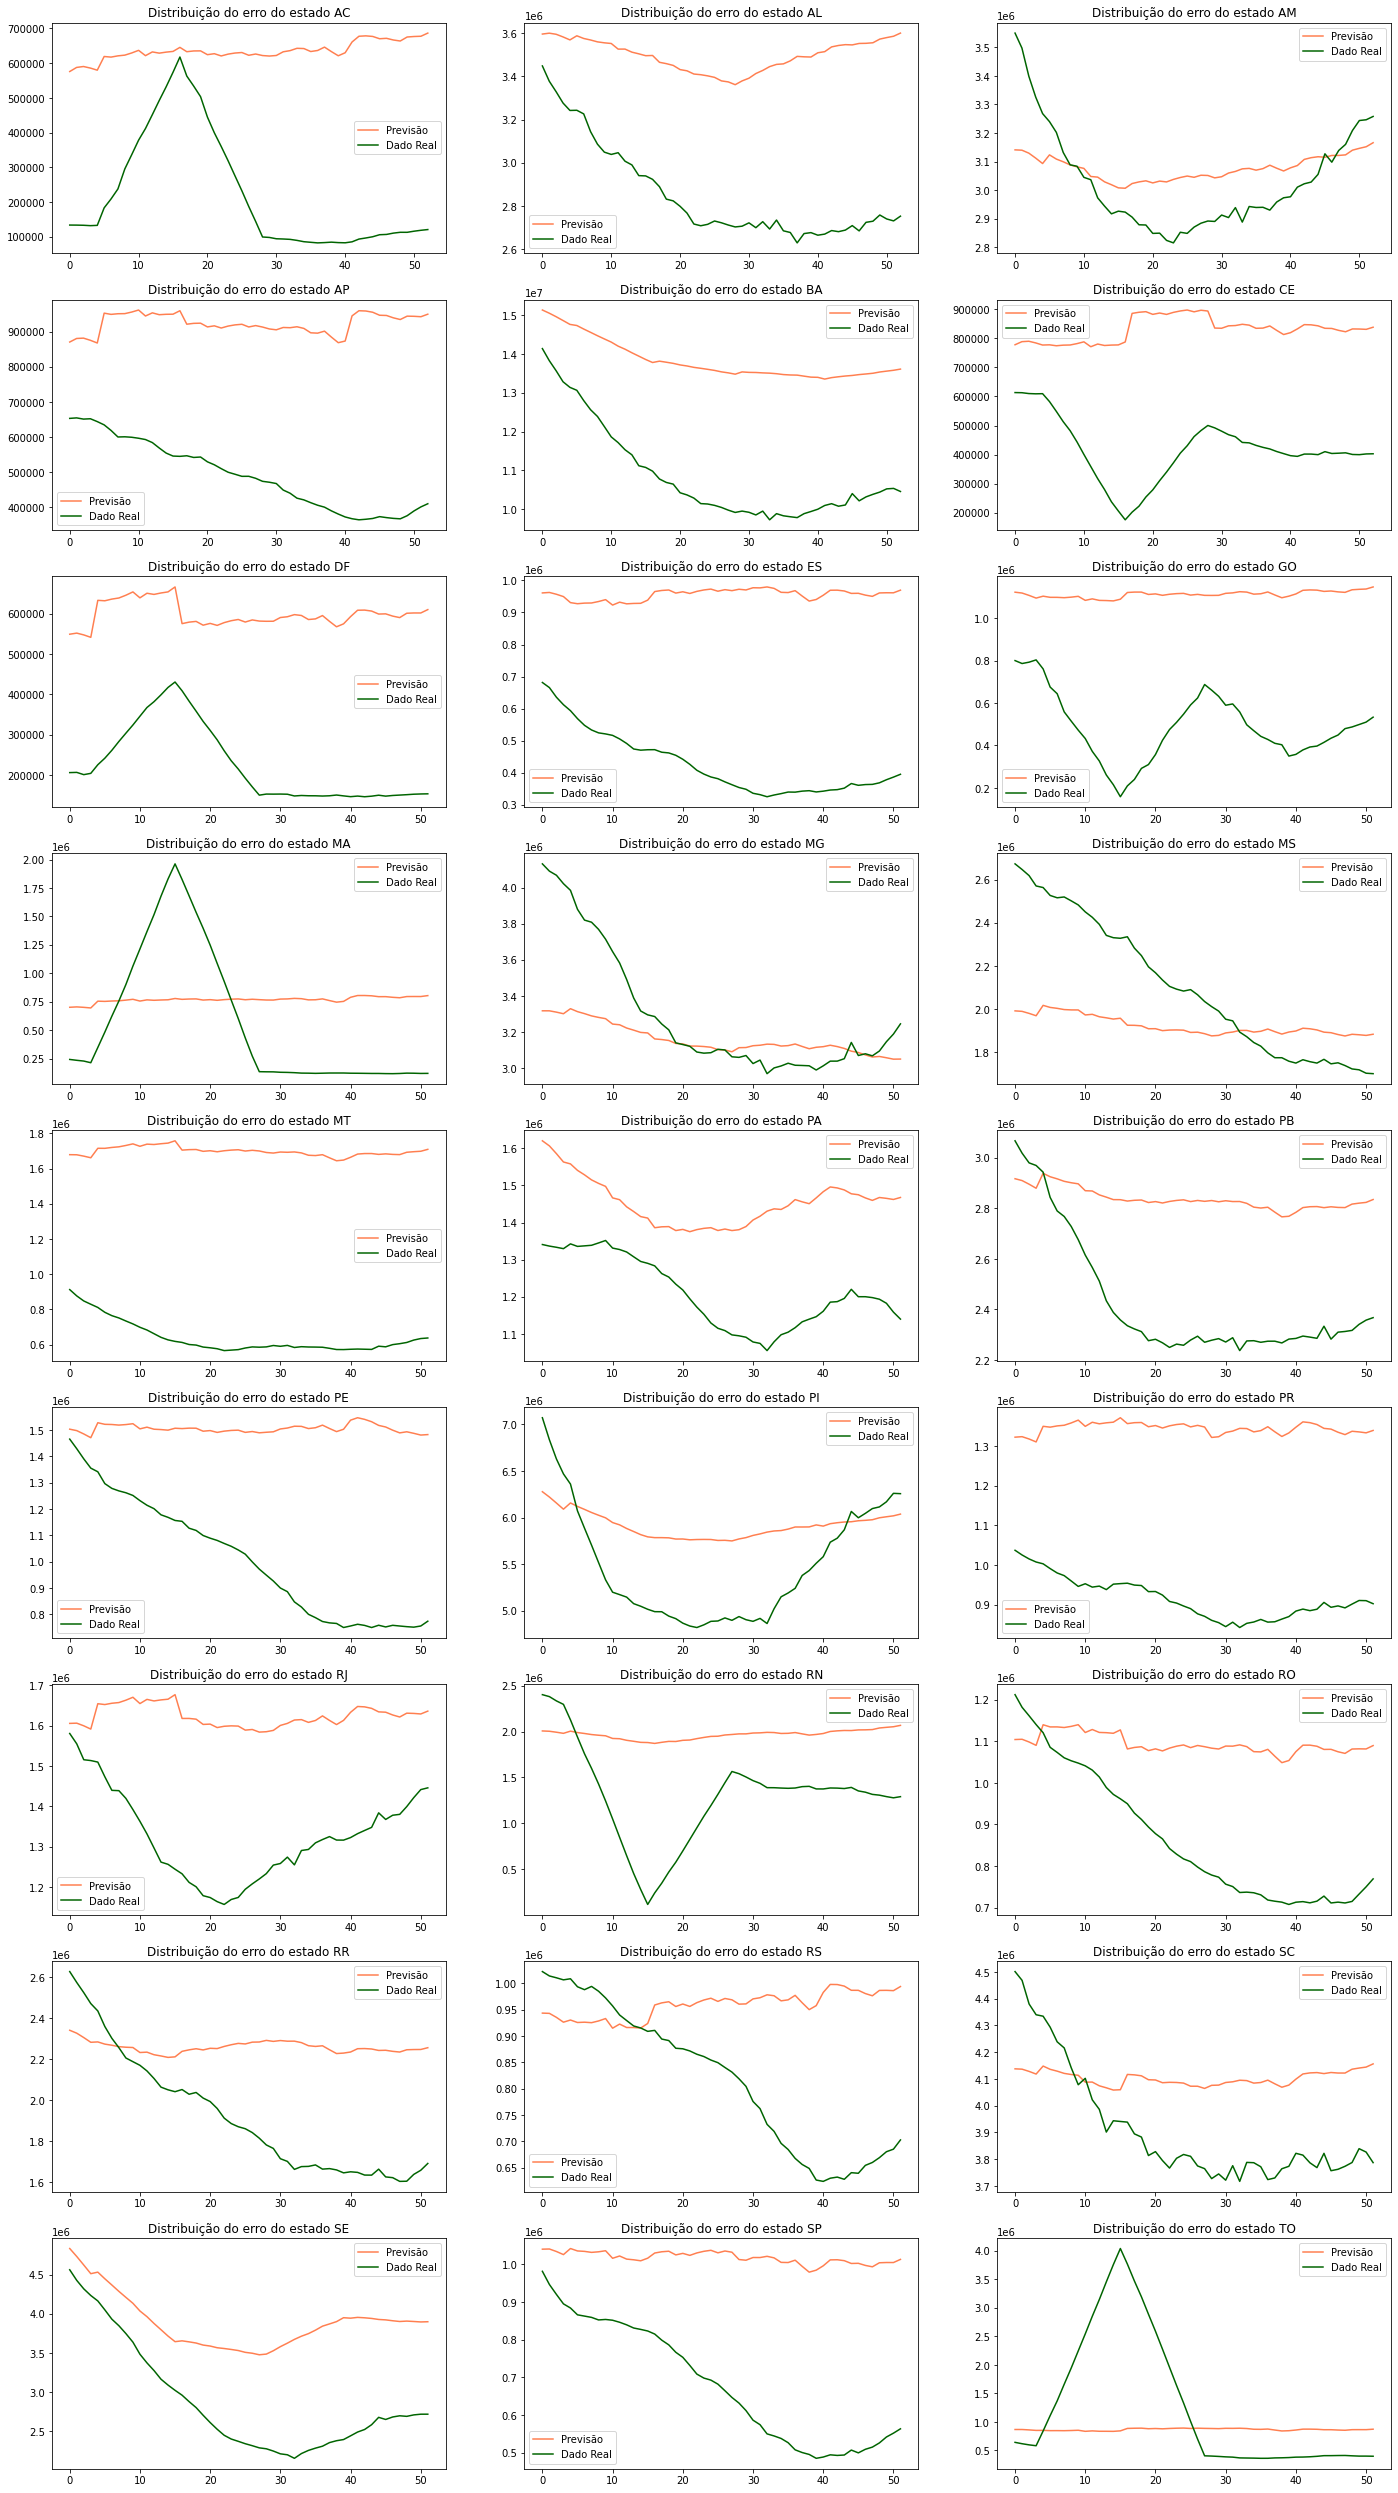

In [245]:
show_predictions_graphs(y_pred_state, y_test_state)

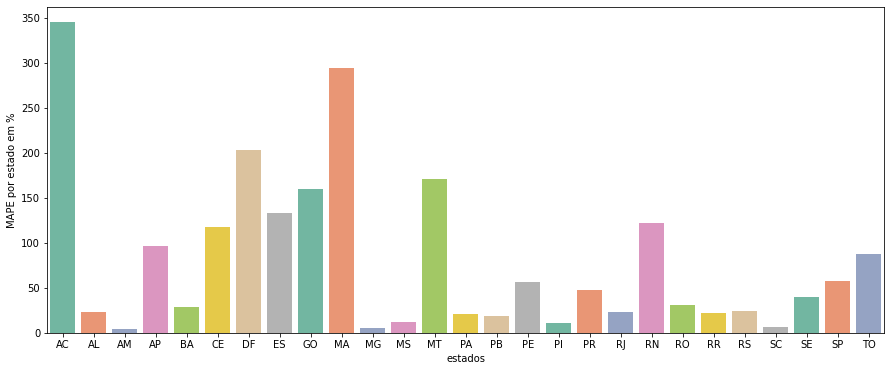

In [246]:
show_error_state(y_pred_state, y_test_state)

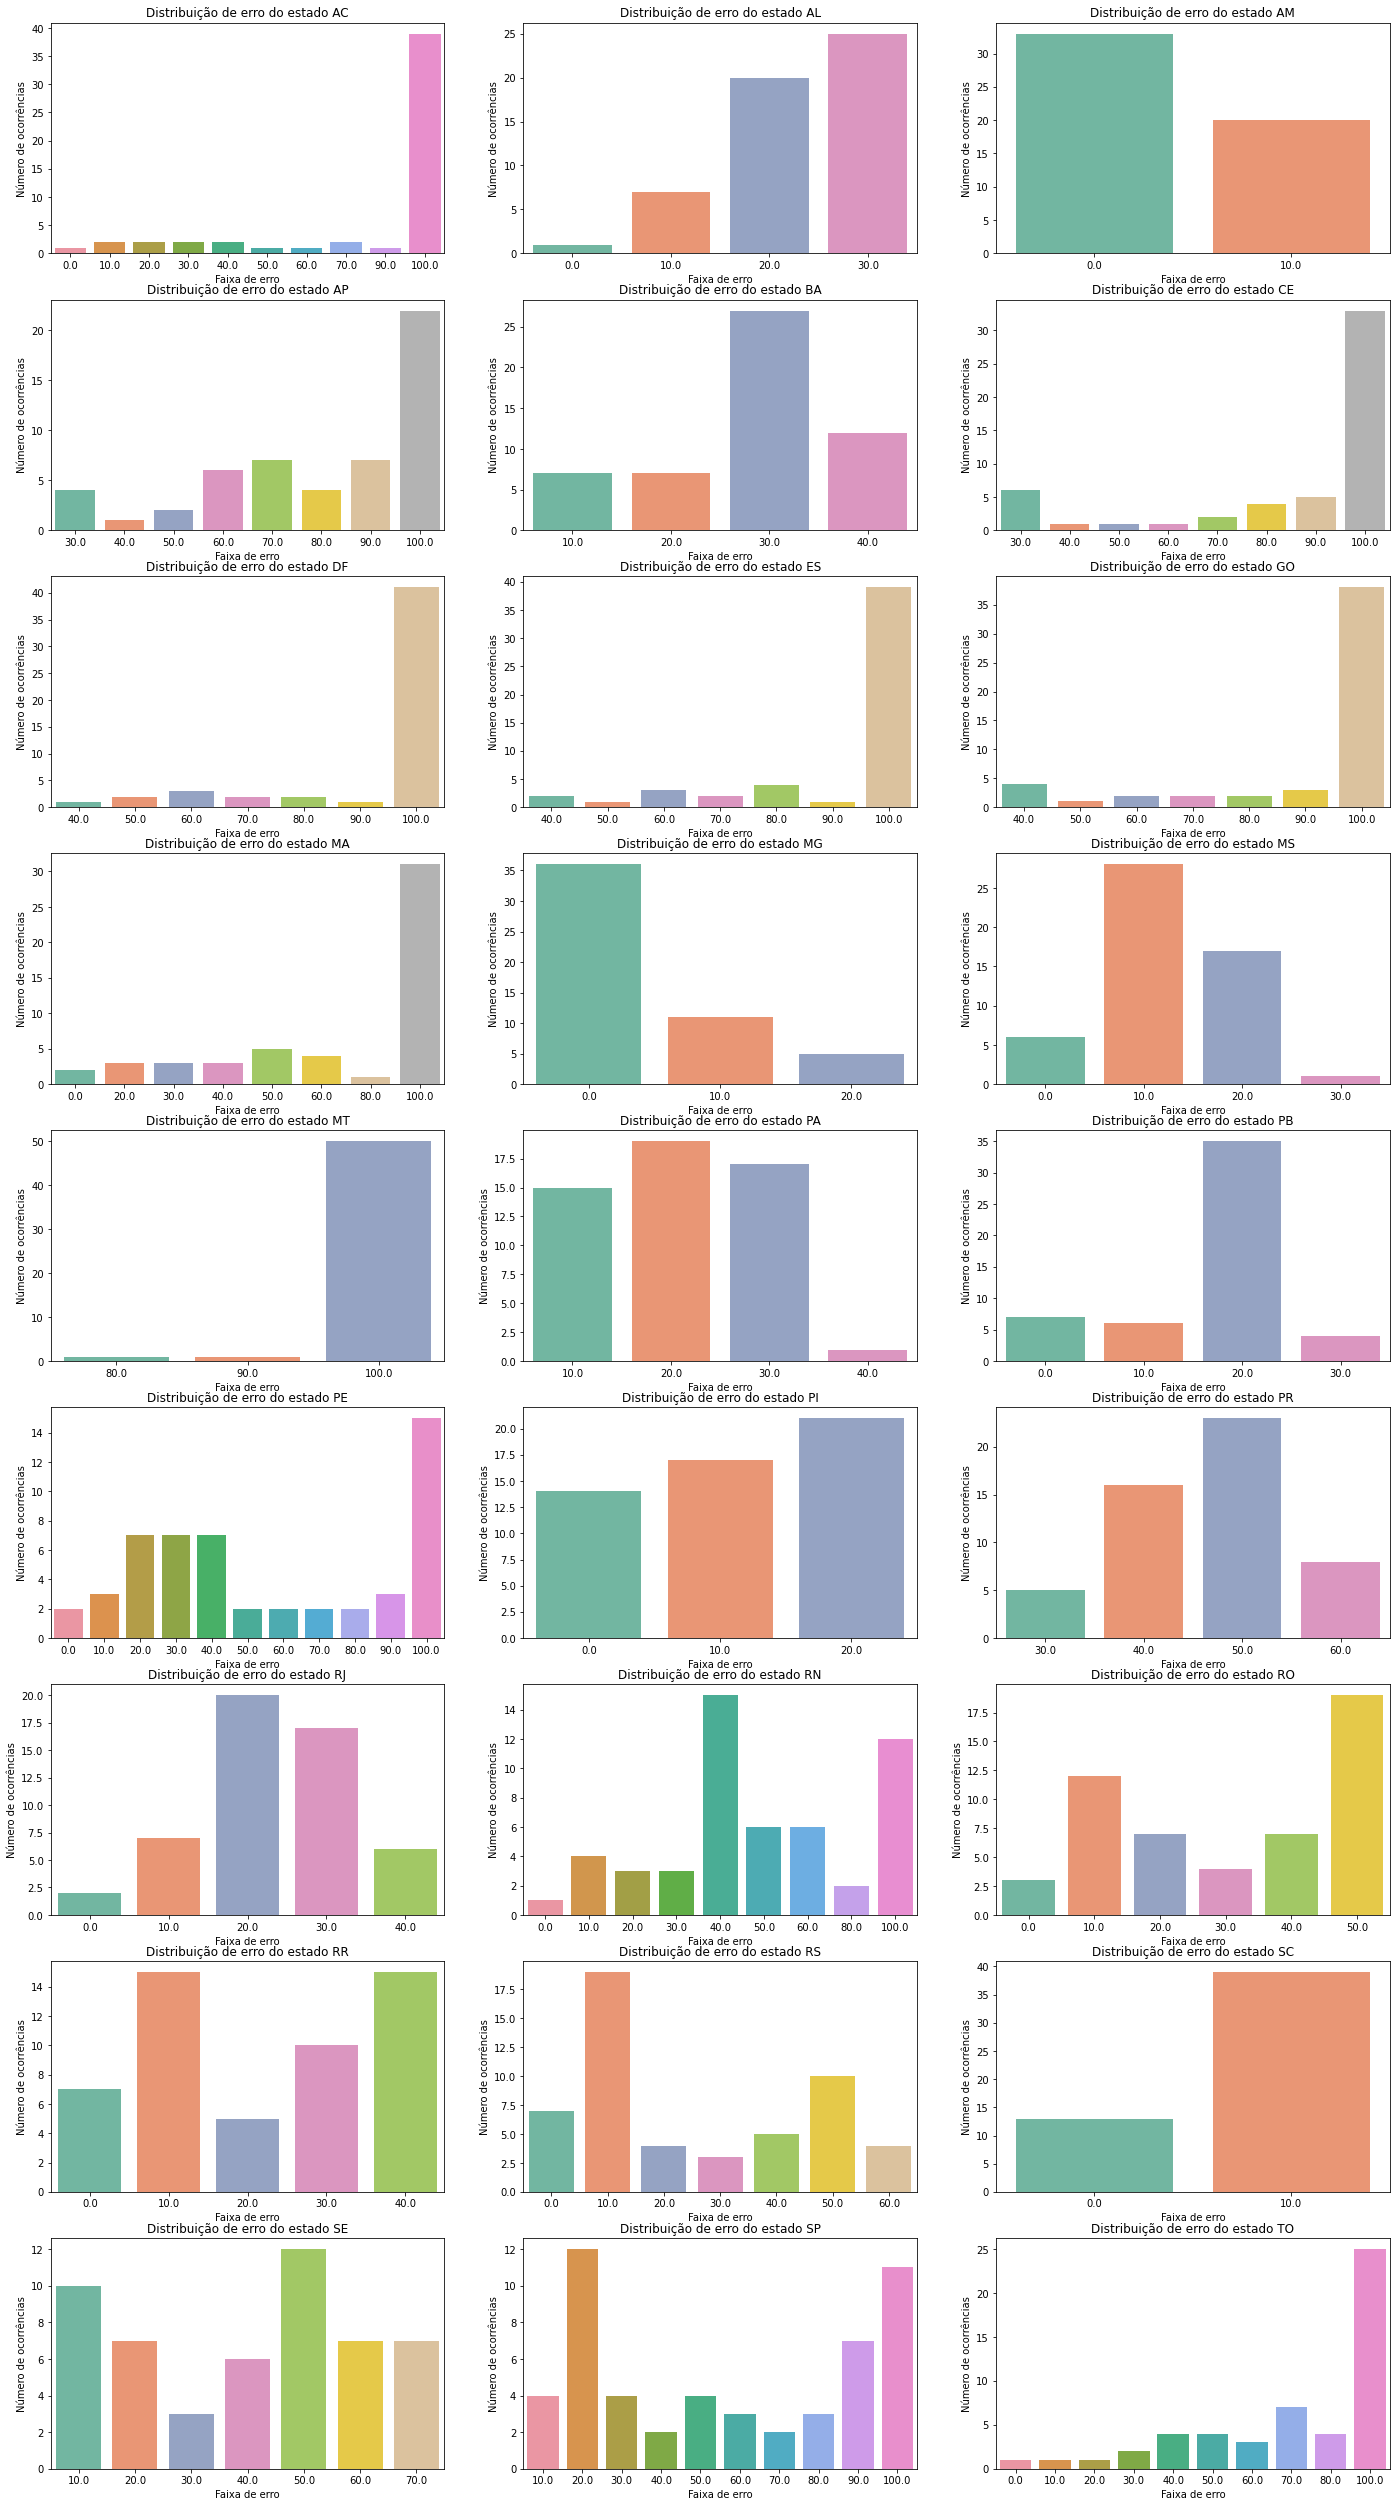

In [247]:
show_error_graphs(y_pred_state, y_test_state)

## Normalizando os dados 

### Normalização com Standard Scaler

In [248]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")['consumo']

In [249]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.8633707902792132


In [250]:
# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 821444.863093807
MAE: 562083.2912963495
MAPE: 0.8010375936536186


In [251]:
y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)

#### Gráficos

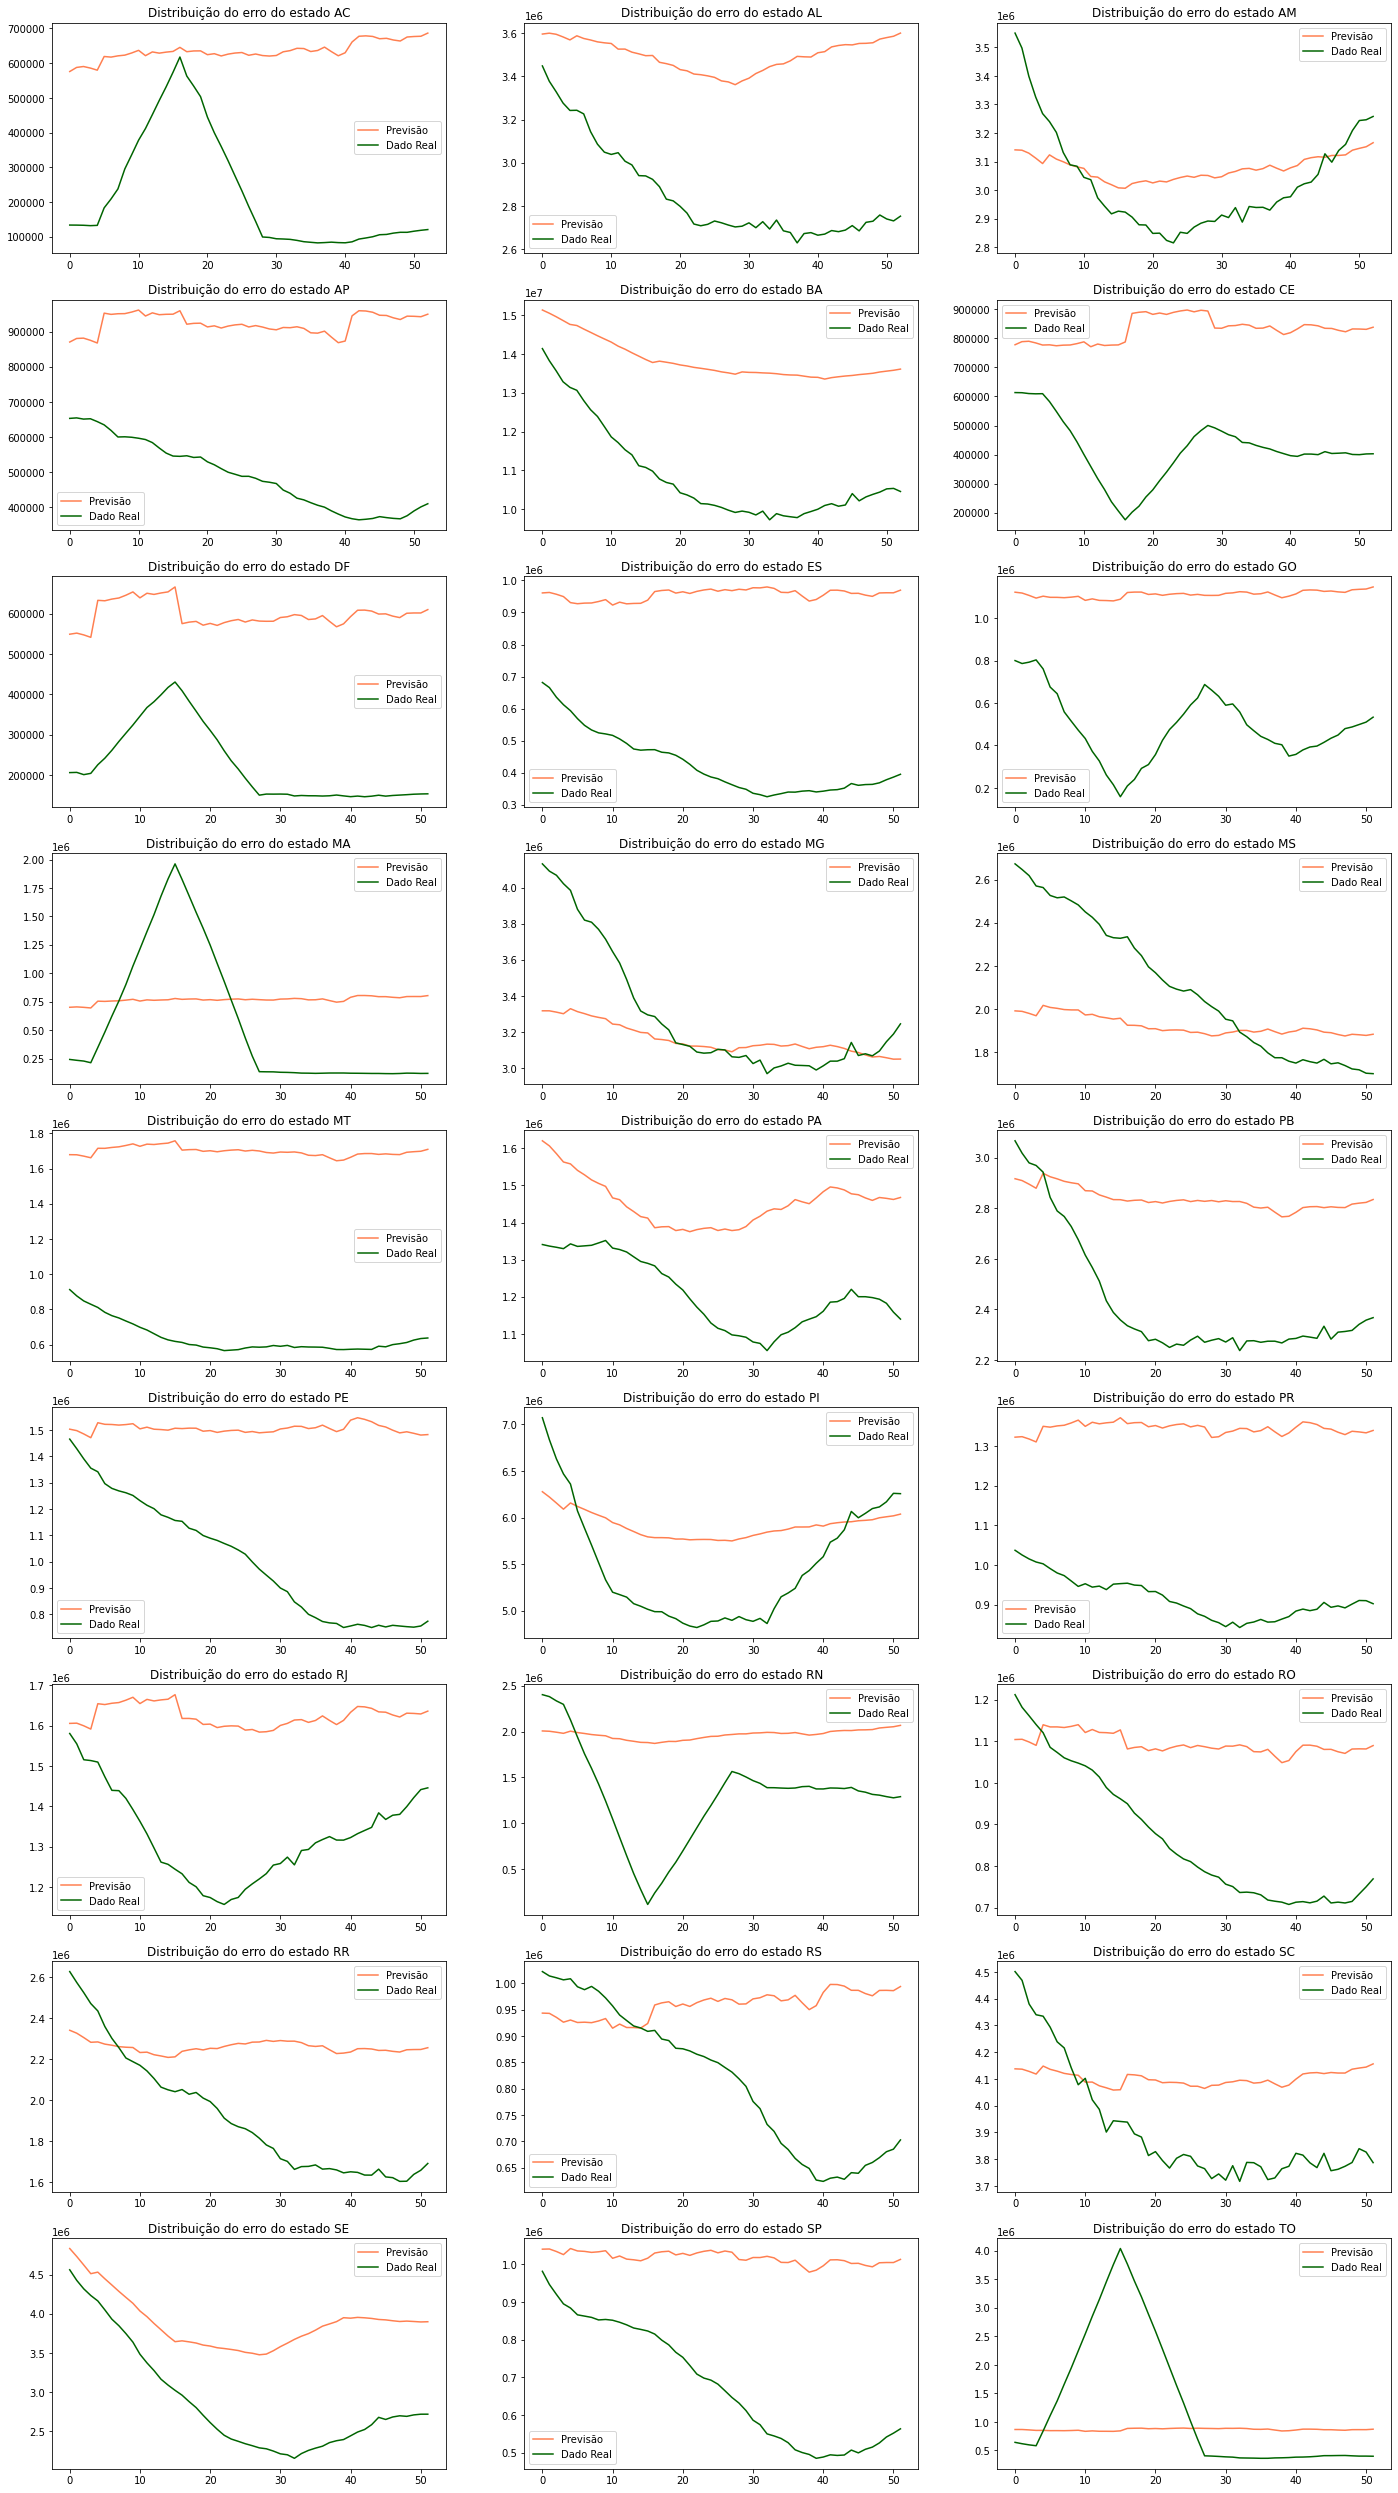

In [252]:
show_predictions_graphs(y_pred_state, y_test_state)

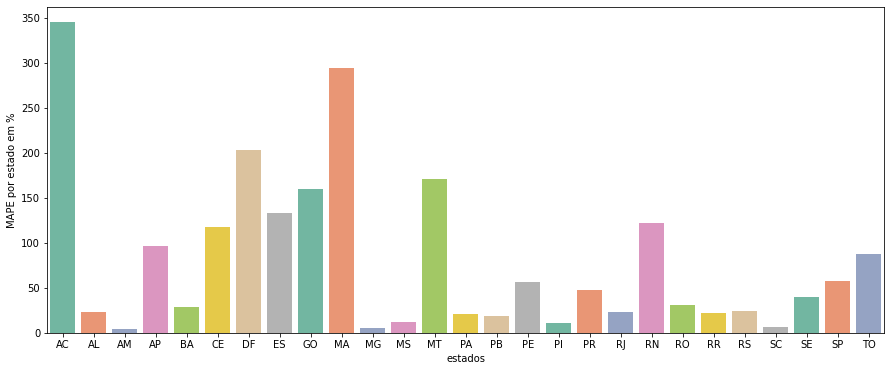

In [253]:
show_error_state(y_pred_state, y_test_state)

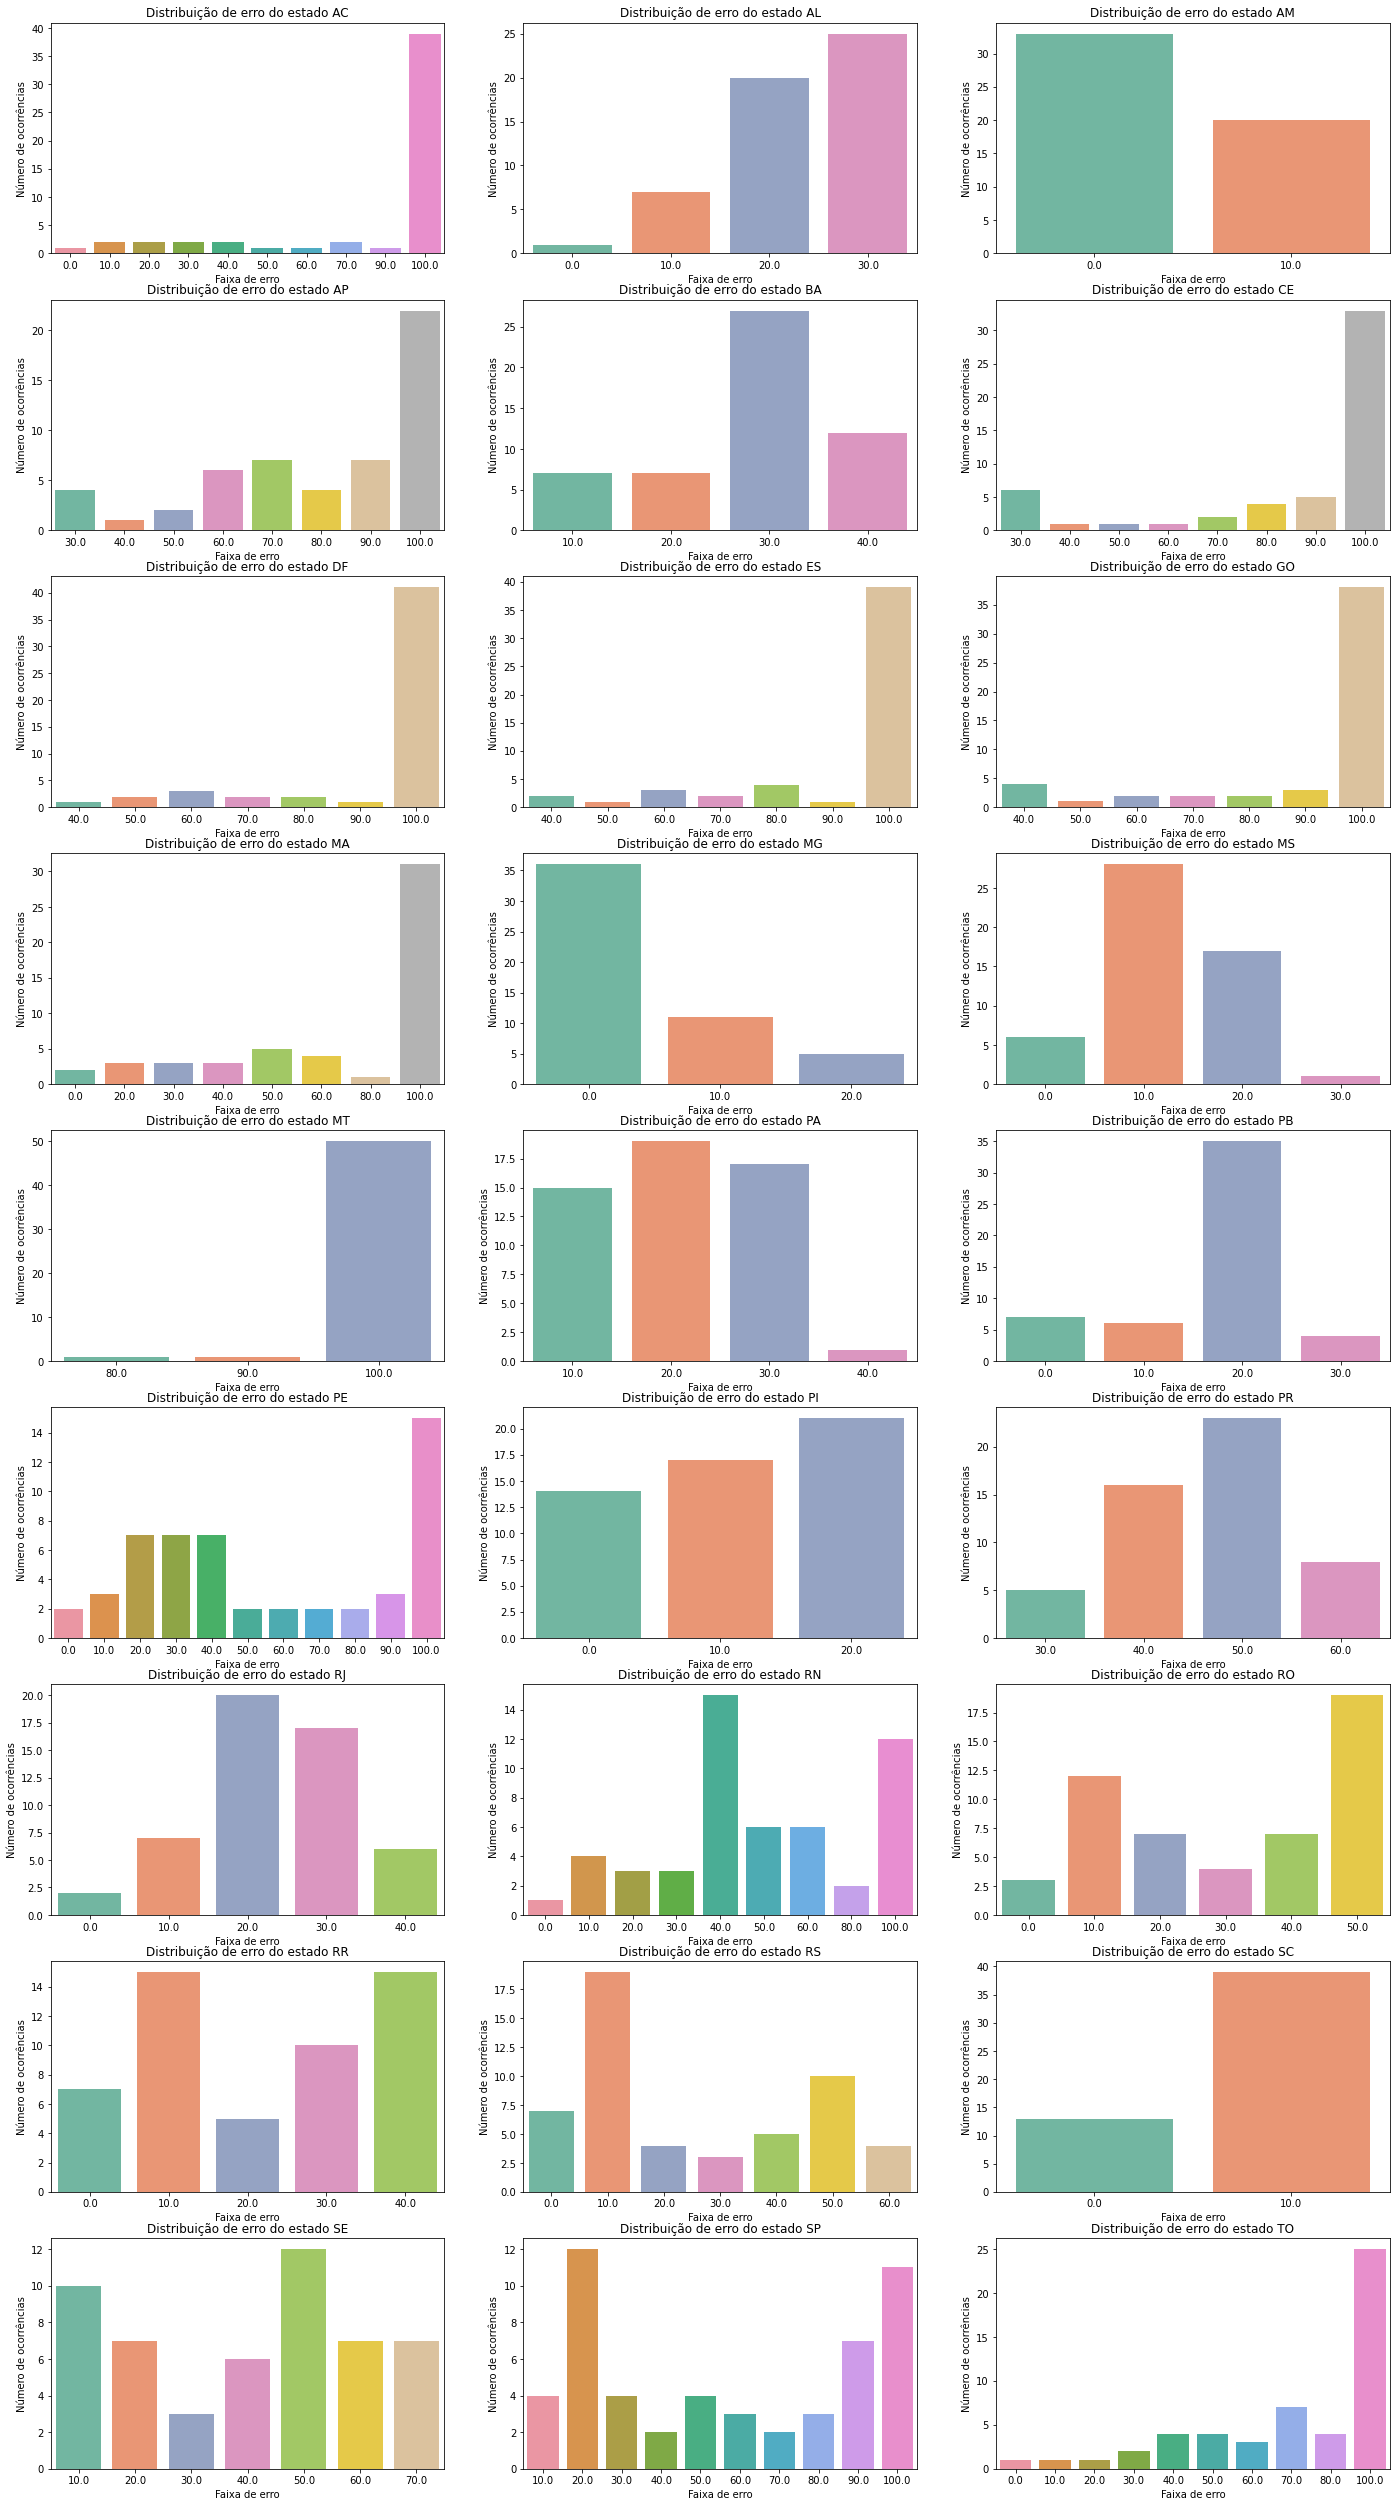

In [254]:
show_error_graphs(y_pred_state, y_test_state)

### MinMax

In [255]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")['consumo']

In [256]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.8633707902792134


In [257]:
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 821444.8630938067
MAE: 562083.2912963482
MAPE: 0.8010375936536166


In [258]:
y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)

In [259]:
# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 821444.8630938067
MAE: 562083.2912963482
MAPE: 0.8010375936536166


#### Gráficos

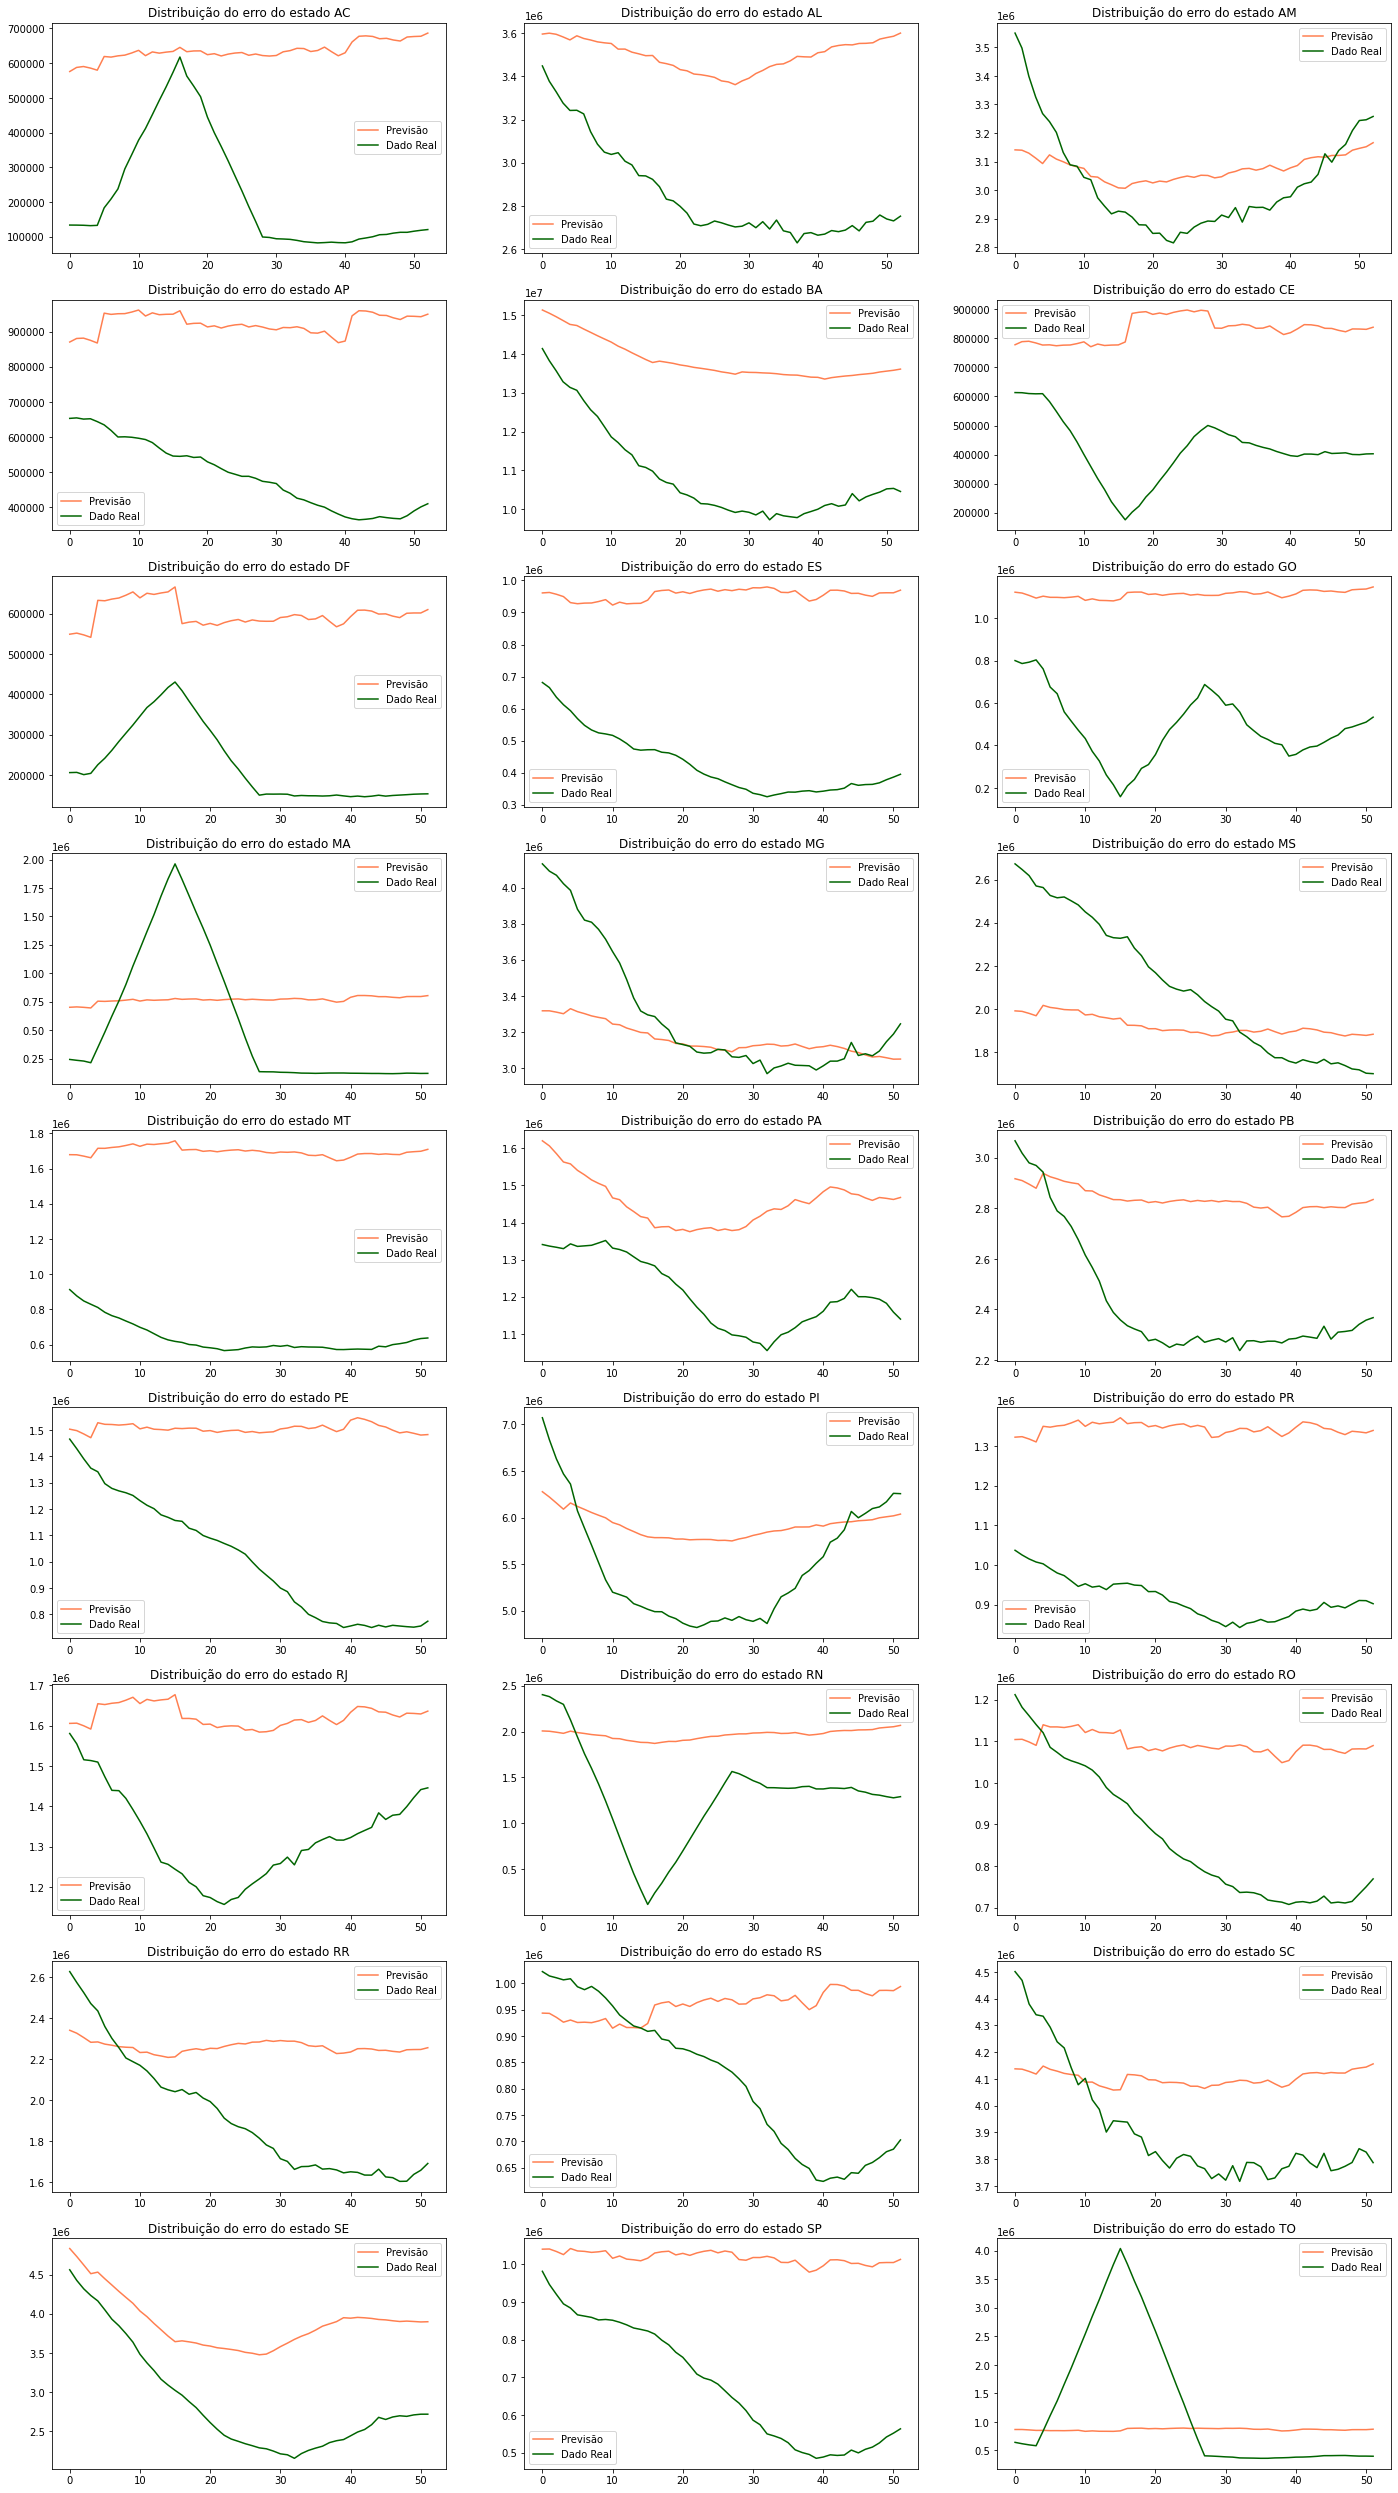

In [260]:
show_predictions_graphs(y_pred_state, y_test_state)

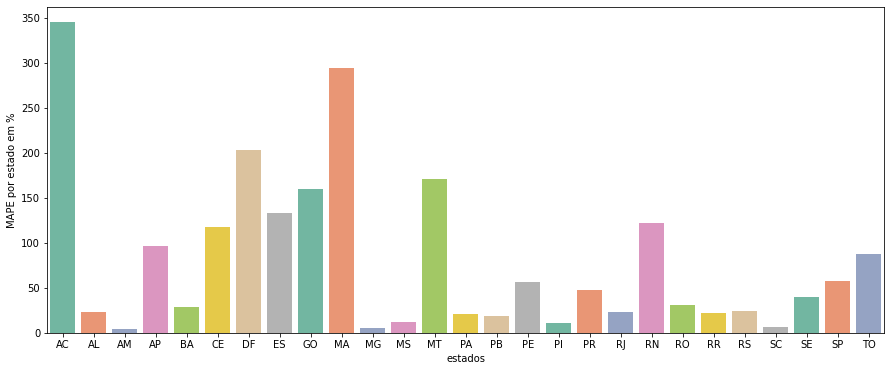

In [261]:
show_error_state(y_pred_state, y_test_state)

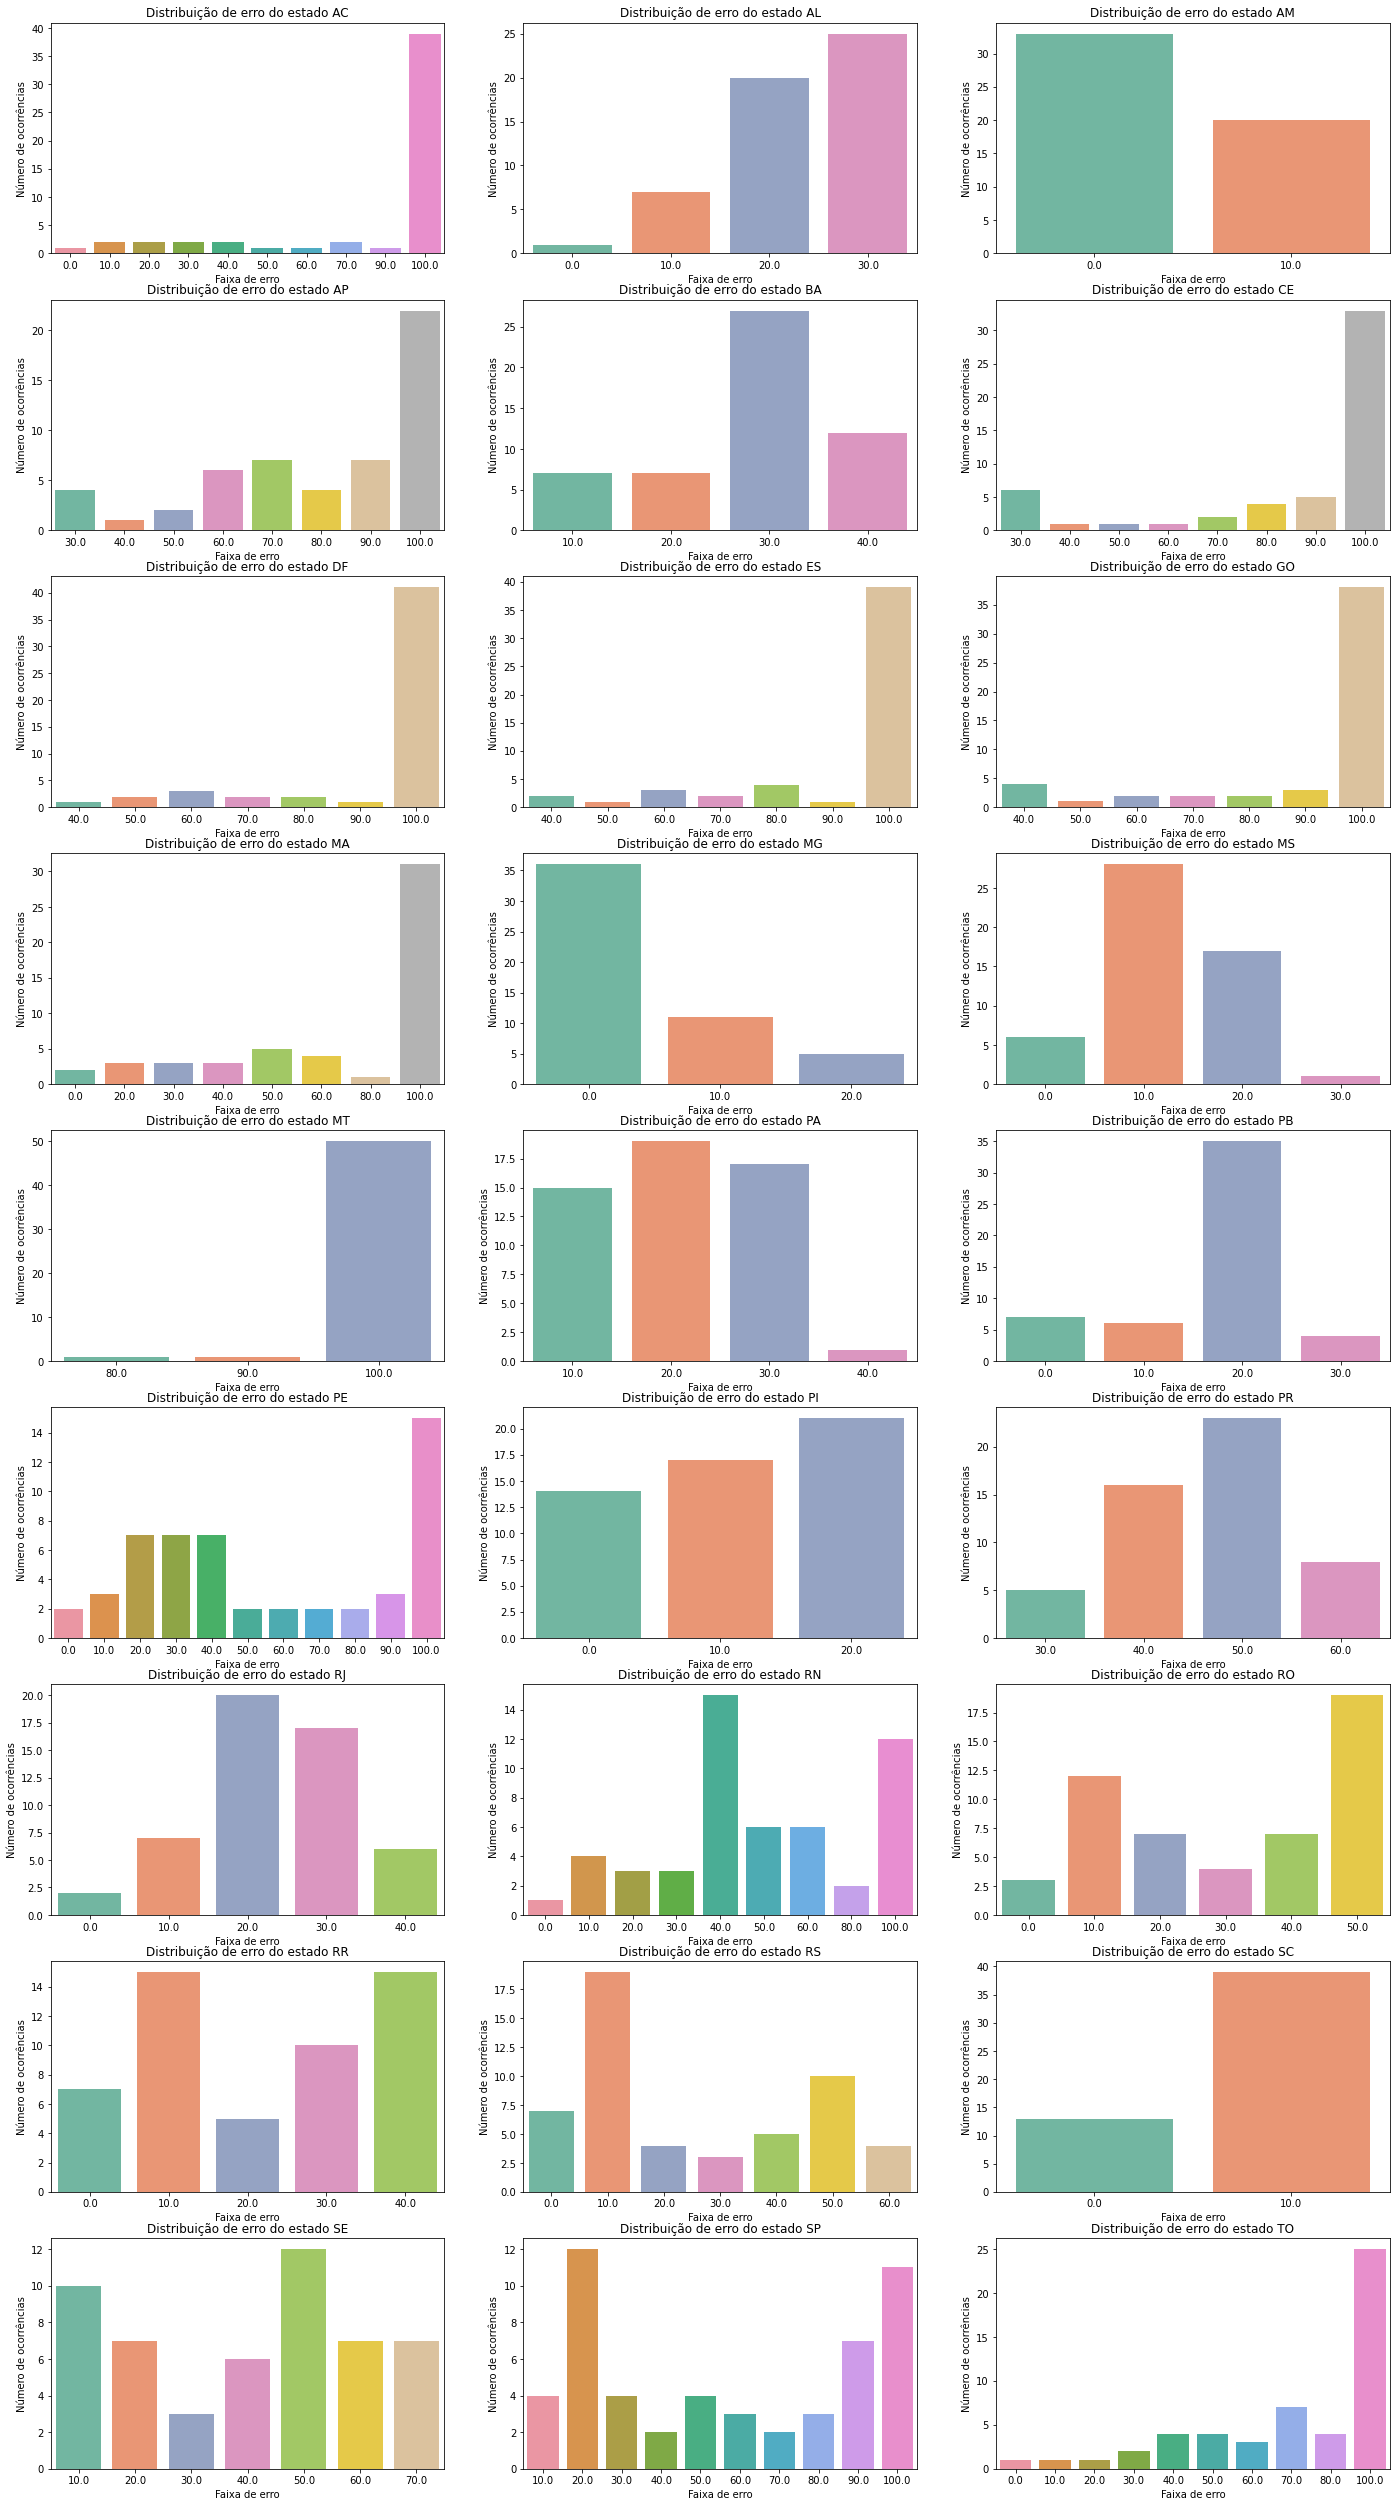

In [262]:
show_error_graphs(y_pred_state, y_test_state)

### Power Transform

In [263]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")['consumo']

In [264]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.8277070292740302


In [265]:
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 922444.8691951182
MAE: 703952.4584120617
MAPE: 0.8511326474542129


In [266]:
y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)

#### Gráficos

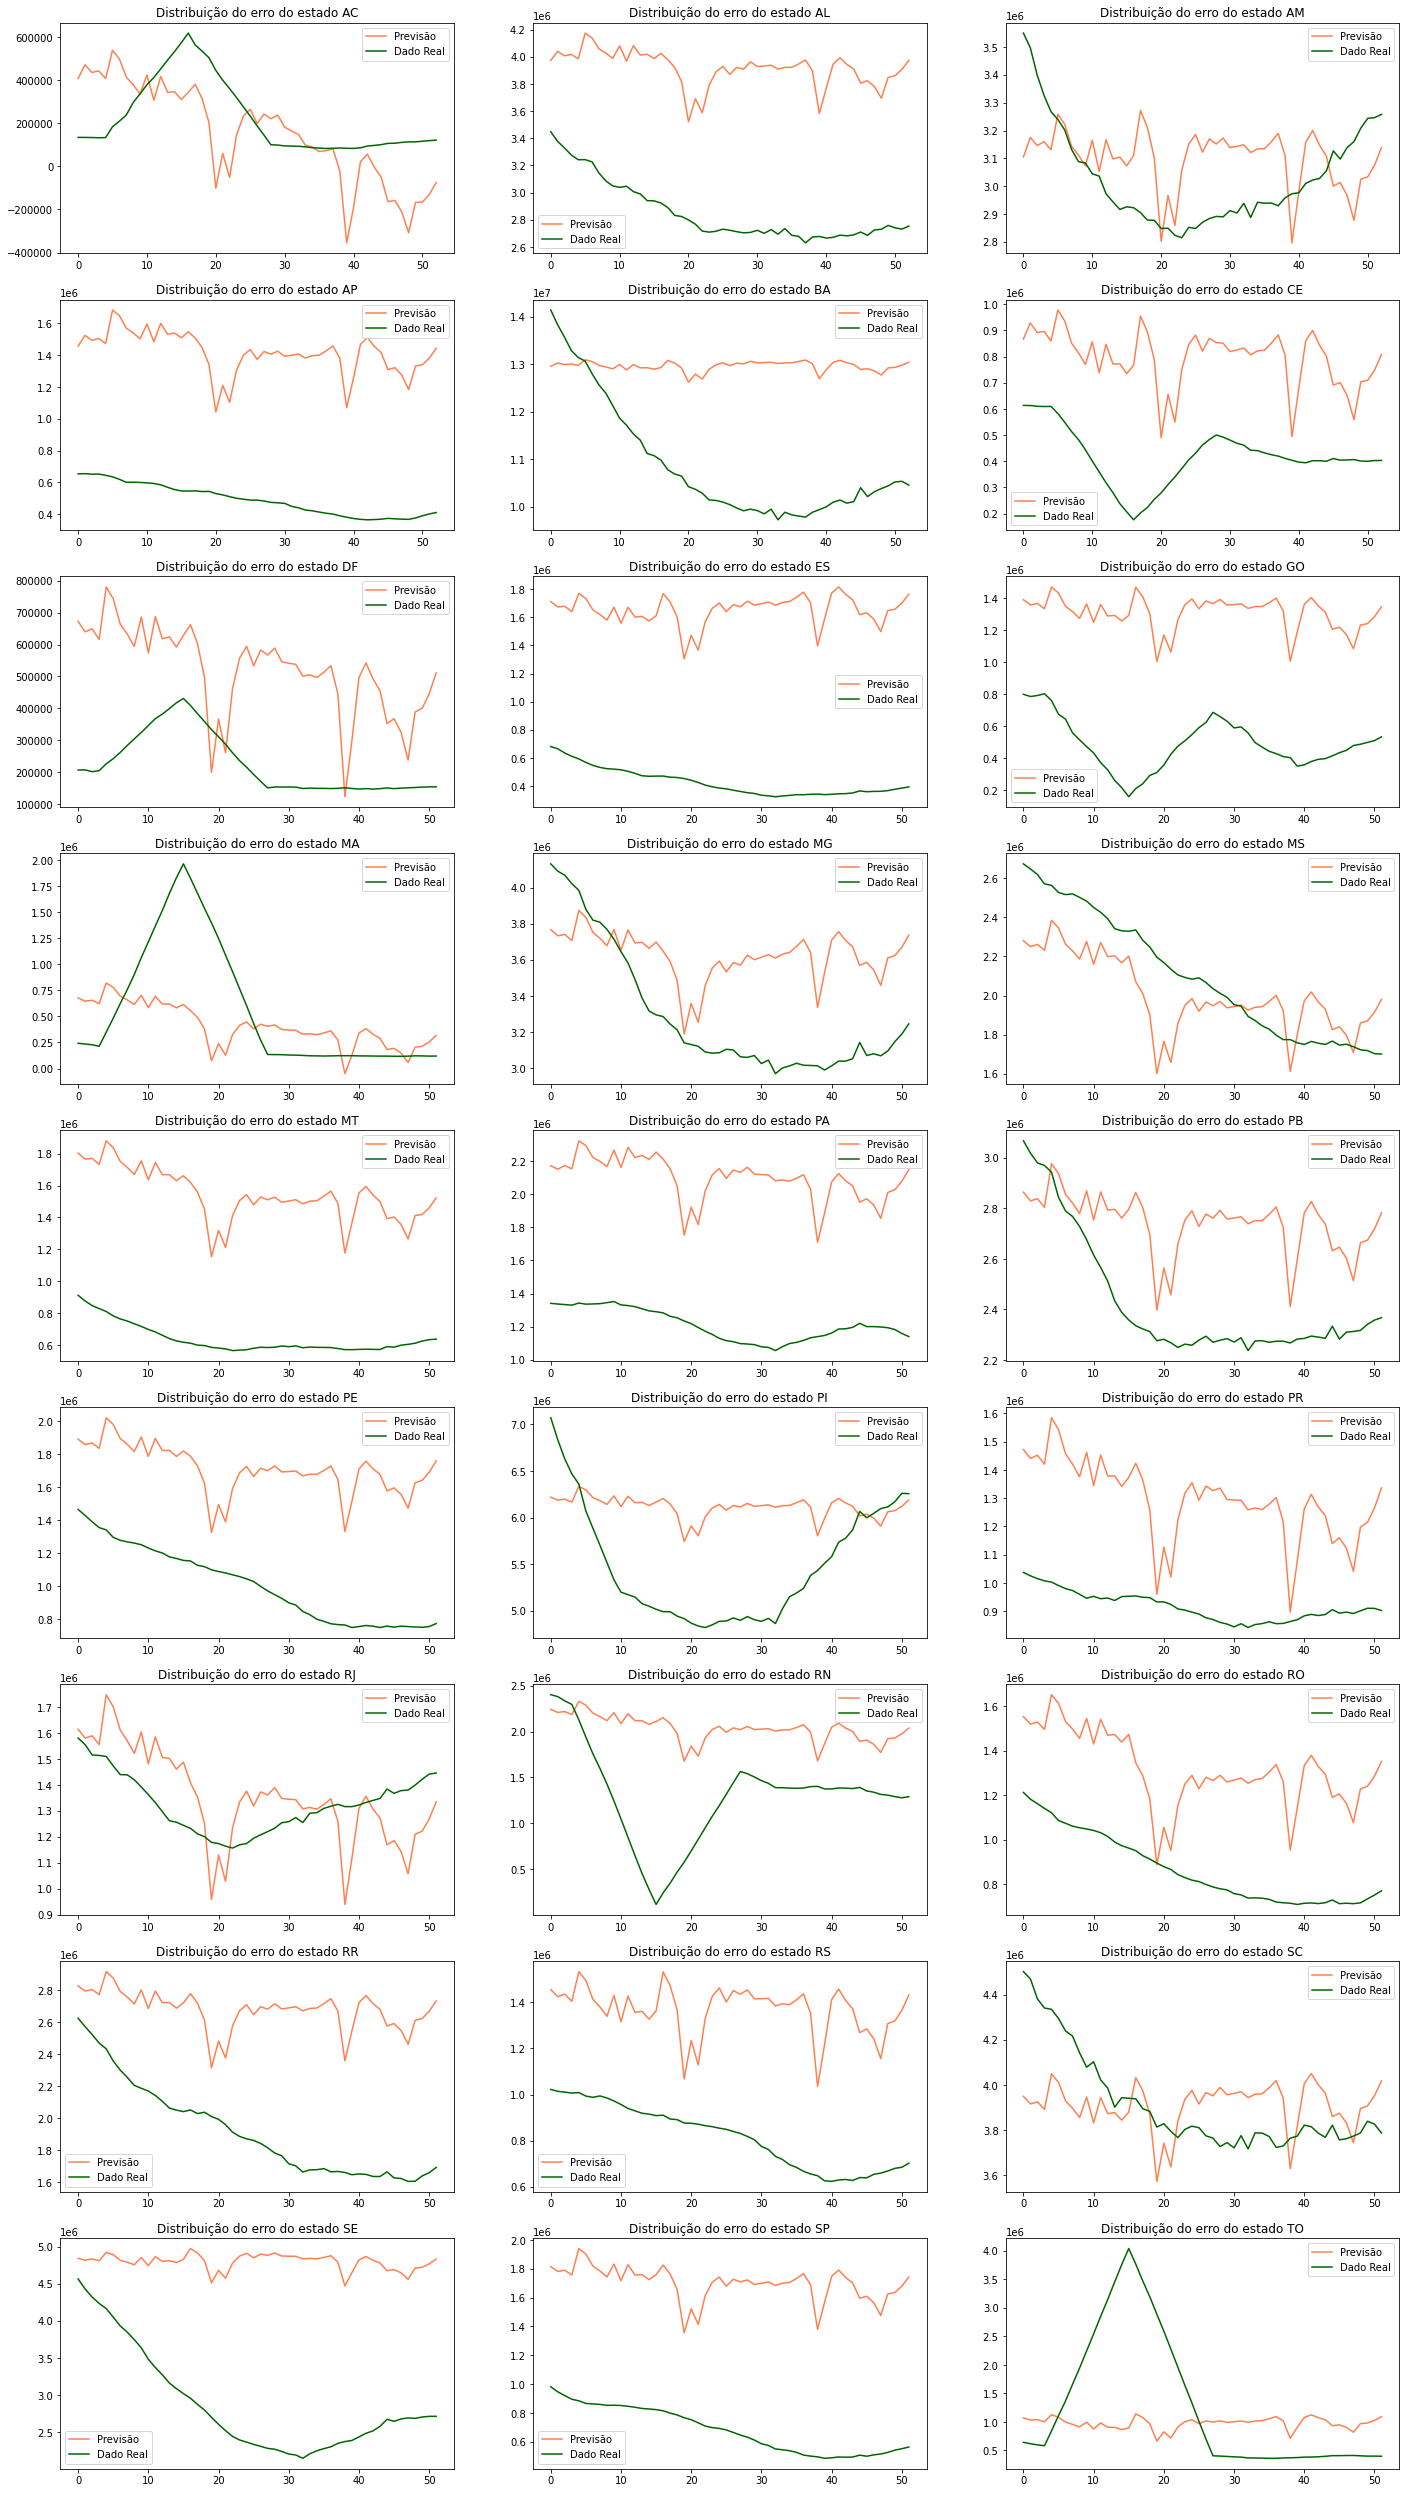

In [267]:
show_predictions_graphs(y_pred_state, y_test_state)

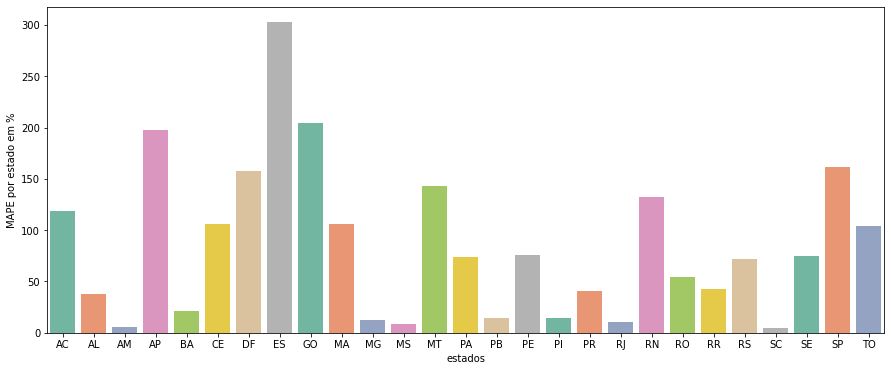

In [268]:
show_error_state(y_pred_state, y_test_state)

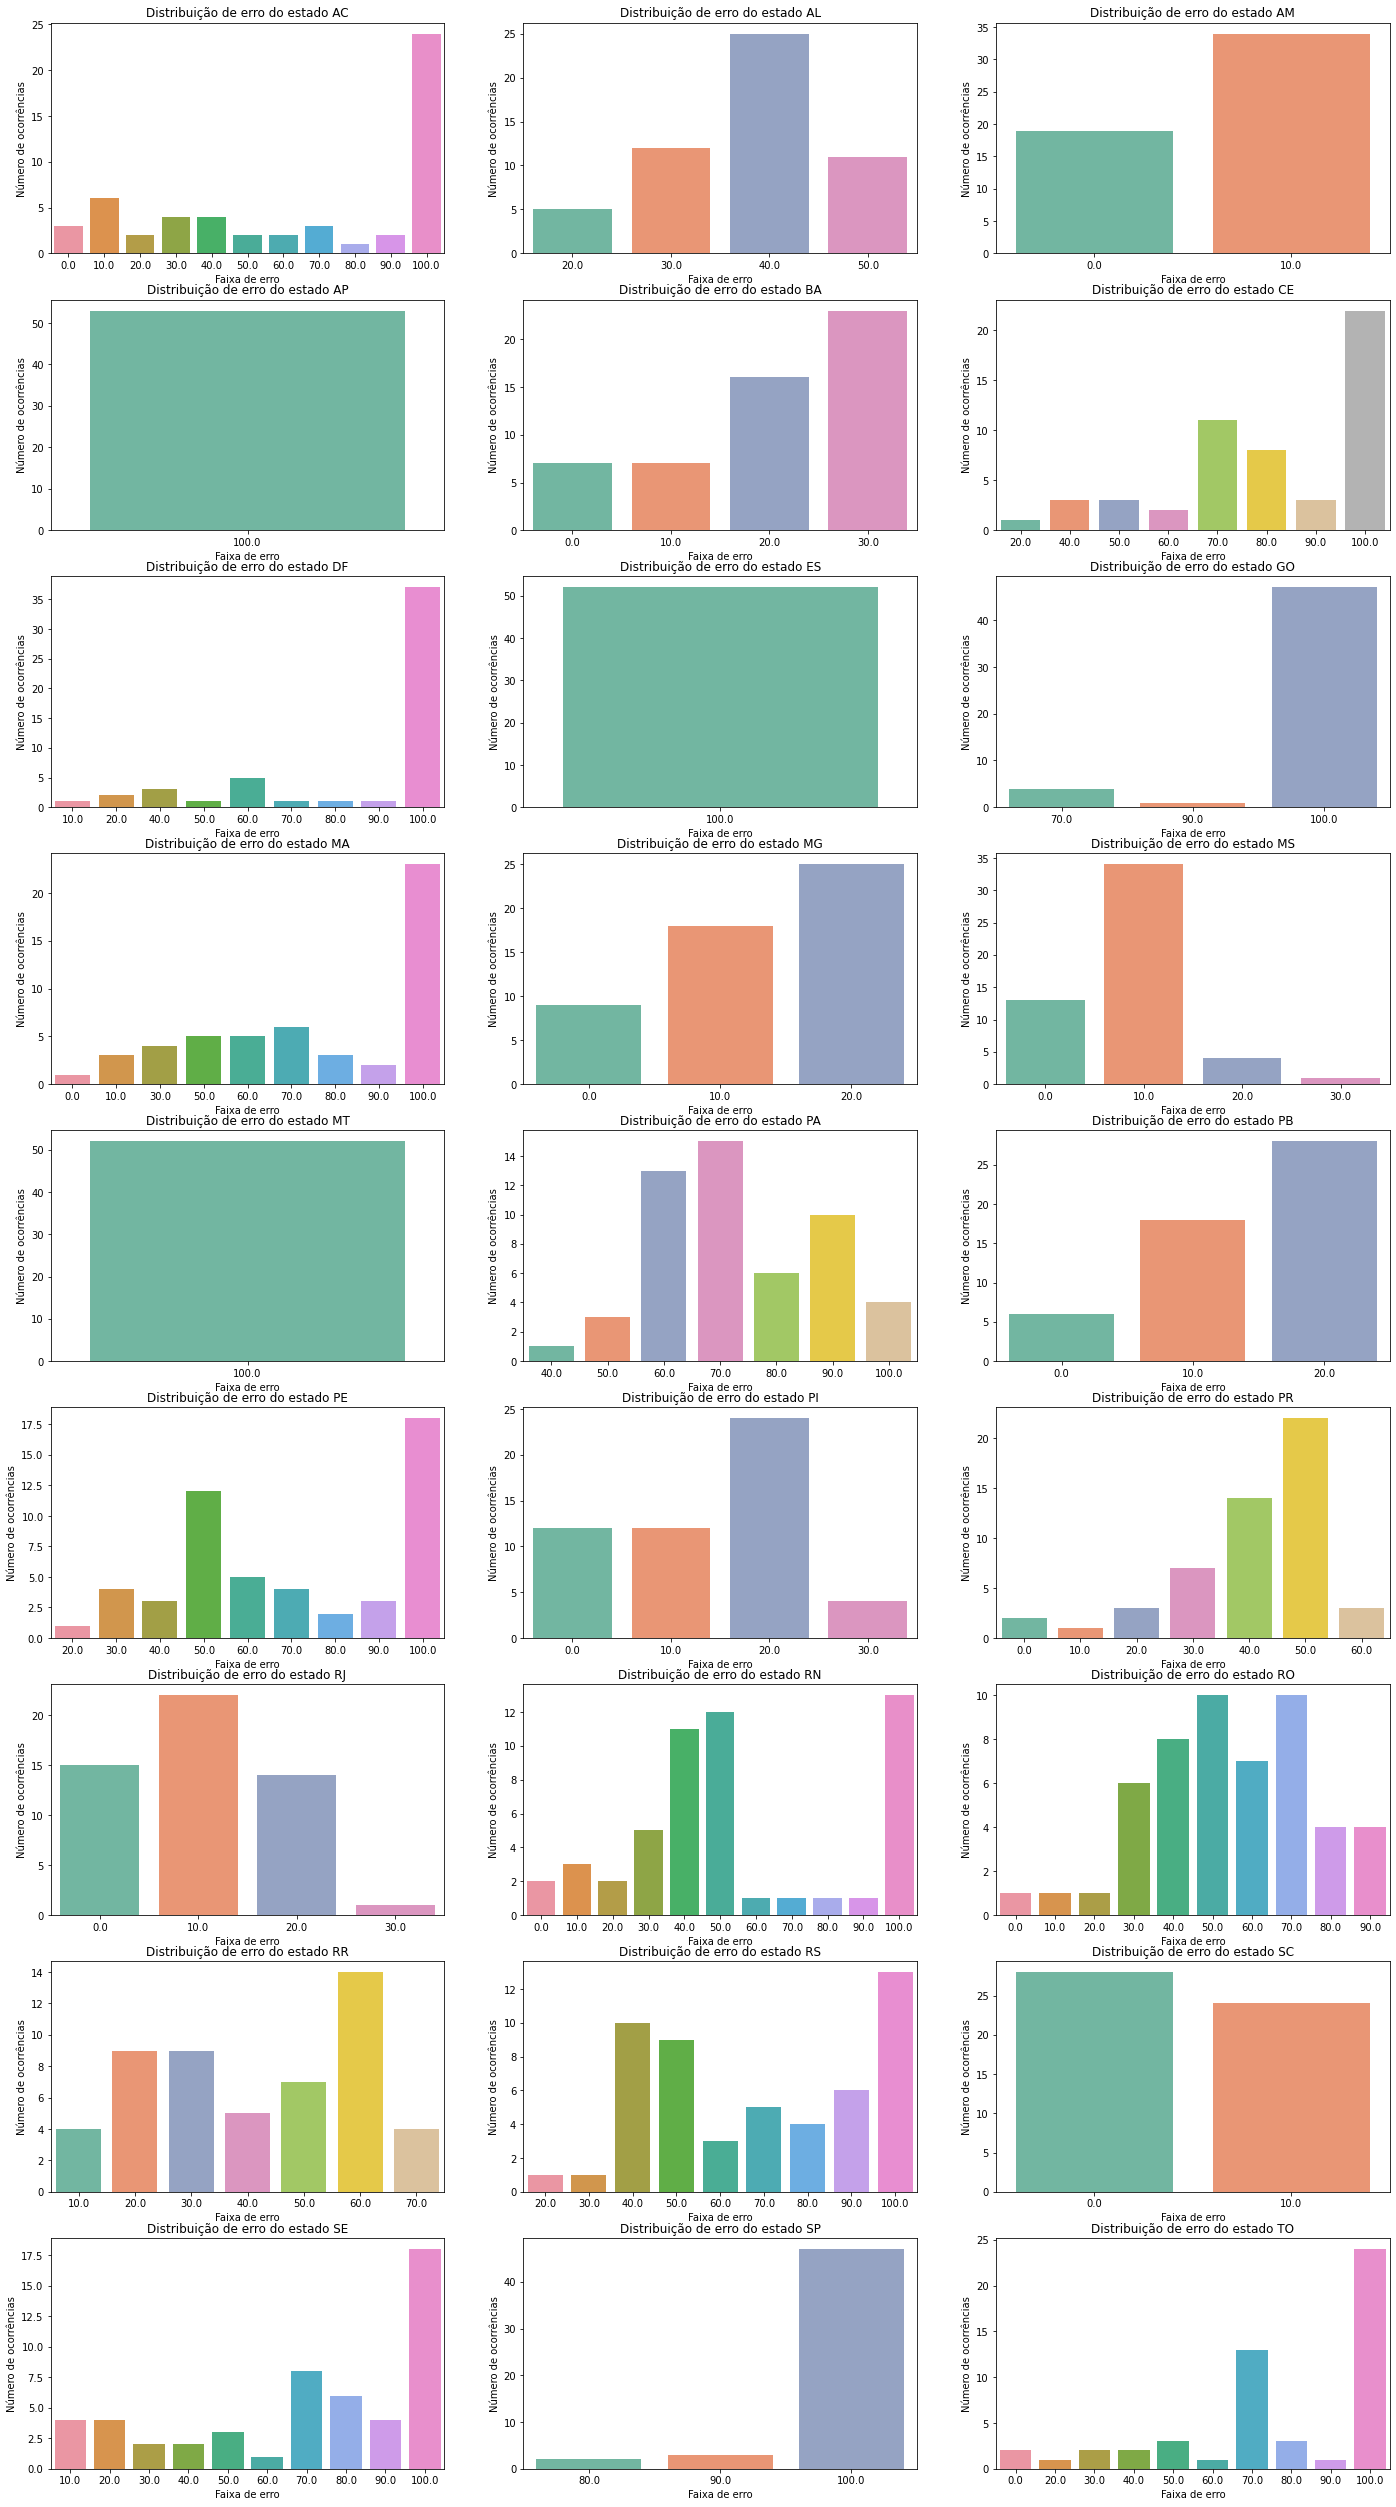

In [269]:
show_error_graphs(y_pred_state, y_test_state)

# Modelo para cada estado

## Sem normalizar os dados

In [270]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

In [271]:
pred = {}

y_test_states = {}

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[i] = regr.predict(x_test)

[AC]: Score: -0.750992500238366
[AL]: Score: -14.056420567314474
[AM]: Score: -1.382839057592474
[AP]: Score: -0.2908057682974141
[BA]: Score: 0.36923760747362977
[CE]: Score: -5.105414508052745
[DF]: Score: -16.722909782308903
[ES]: Score: -9.72146085538822
[GO]: Score: -9.974795685630422
[MA]: Score: 0.6690764647677323
[MG]: Score: -2.00182416906581
[MS]: Score: -11.409307402538266
[MT]: Score: -4.669674327653356
[PA]: Score: -4.7915783340369025
[PB]: Score: -1.0719845711261455
[PE]: Score: -10.41590673876142
[PI]: Score: -11.71013179037318
[PR]: Score: -64.94931321444959
[RJ]: Score: -0.2836127442808478
[RN]: Score: -6.987354804743409
[RO]: Score: -0.5043290391727191
[RR]: Score: -0.6622651136950763
[RS]: Score: -40.952290847726566
[SC]: Score: -15.313977815498781
[SE]: Score: -1.776665945416668
[SP]: Score: -38.09499113105228
[TO]: Score: -0.6921884382129535


#### Gráficos

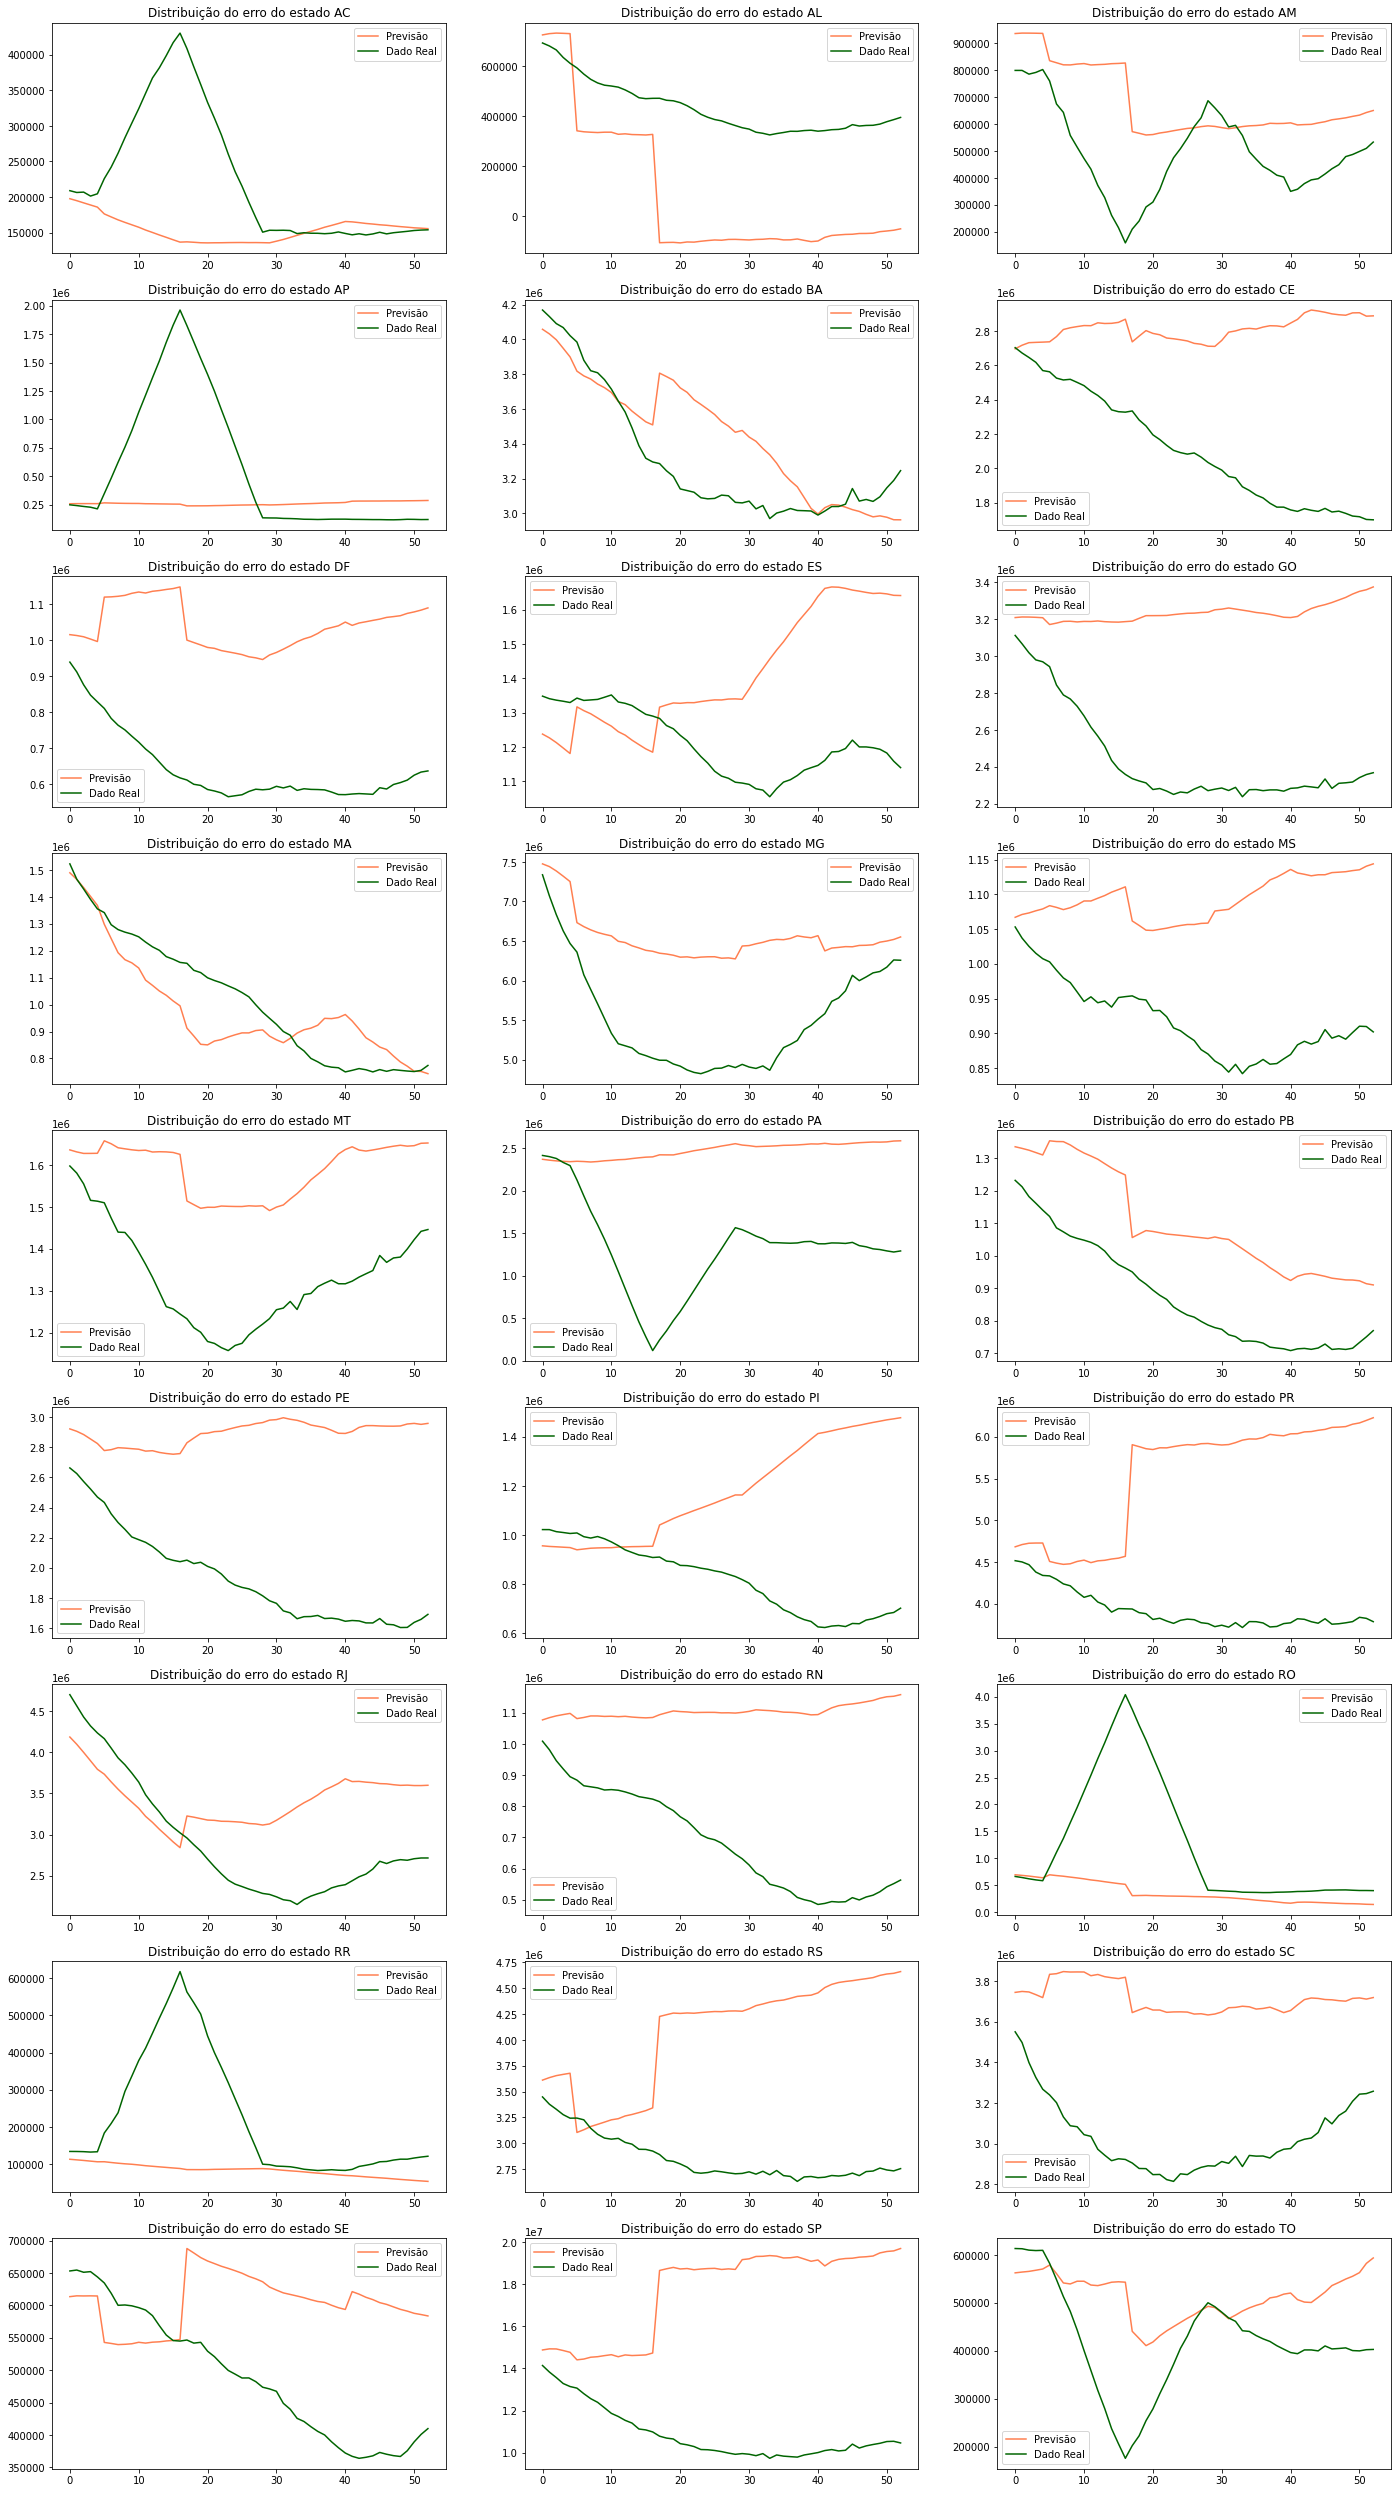

In [272]:
show_predictions_graphs(pred, y_test_states)

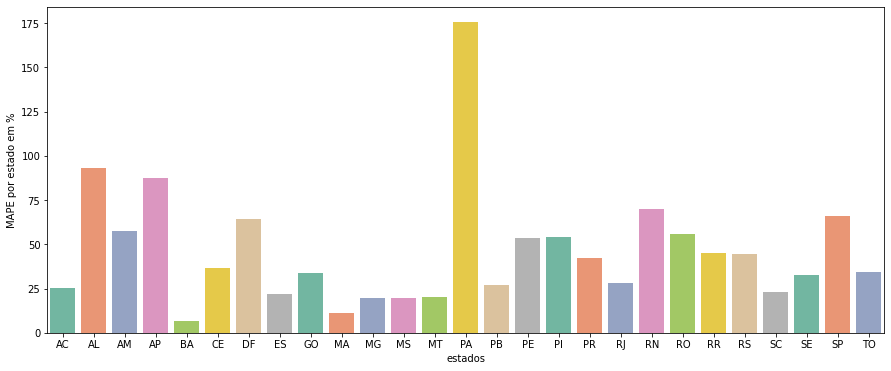

In [273]:
show_error_state(pred, y_test_states)

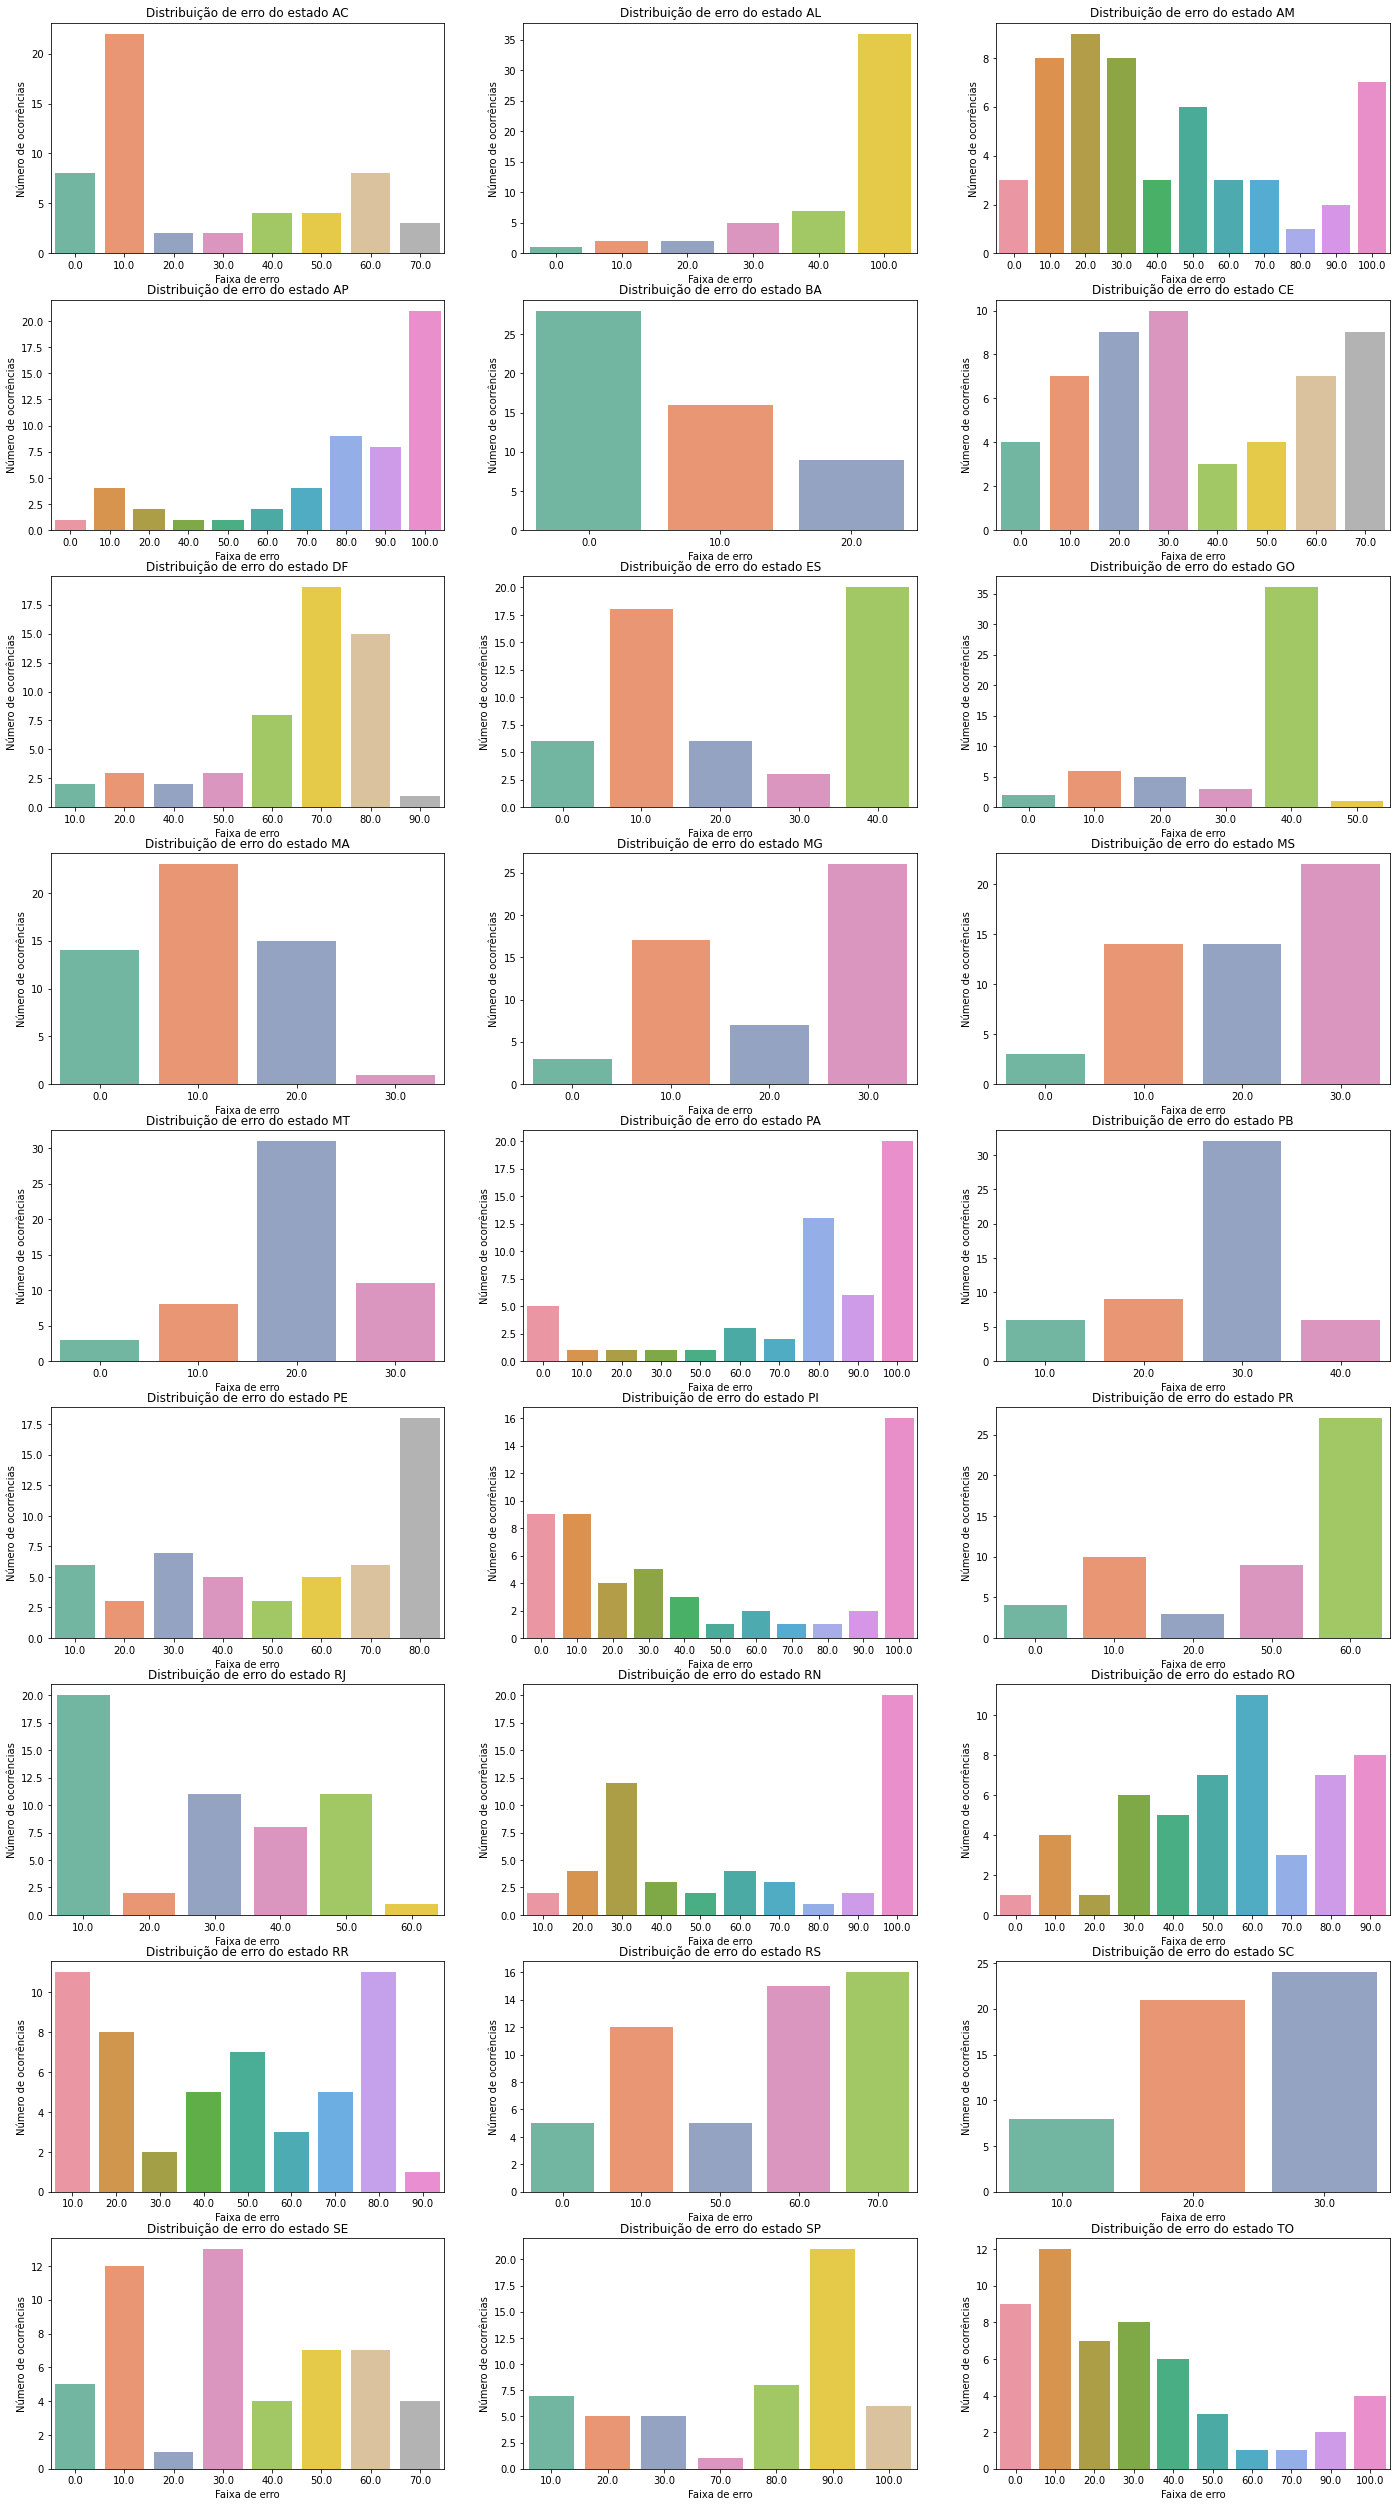

In [274]:
show_error_graphs(pred, y_test_states)

## Normalizando os dados

### Normalização com Standard Scaler

In [275]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

In [276]:
pred = {}

y_test_states = {}

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    # normalizacao
    
    # calcula media e desvio padrao do treino e normaliza os dados
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[i] = regr.predict(x_test)

[AC]: Score: -0.7509925332506879
[AL]: Score: -14.056420215059207
[AM]: Score: -1.3828389653517972
[AP]: Score: -0.2908057688507988
[BA]: Score: 0.36923758556800546
[CE]: Score: -5.105414715080021
[DF]: Score: -16.72290987946494
[ES]: Score: -9.721461030454764
[GO]: Score: -9.974795658316756
[MA]: Score: 0.6690764163525774
[MG]: Score: -2.001824172081302
[MS]: Score: -11.409307467112093
[MT]: Score: -4.669674154123312
[PA]: Score: -4.791578127023646
[PB]: Score: -1.0719848243626058
[PE]: Score: -10.41590672797206
[PI]: Score: -11.710130758837778
[PR]: Score: -64.94931343920467
[RJ]: Score: -0.28361275891647053
[RN]: Score: -6.9873547691989595
[RO]: Score: -0.5043290398342921
[RR]: Score: -0.6622651141020863
[RS]: Score: -40.95229057311679
[SC]: Score: -15.31397781796889
[SE]: Score: -1.7766657334494615
[SP]: Score: -38.09499341995164
[TO]: Score: -0.6921884344658253


#### Gráficos

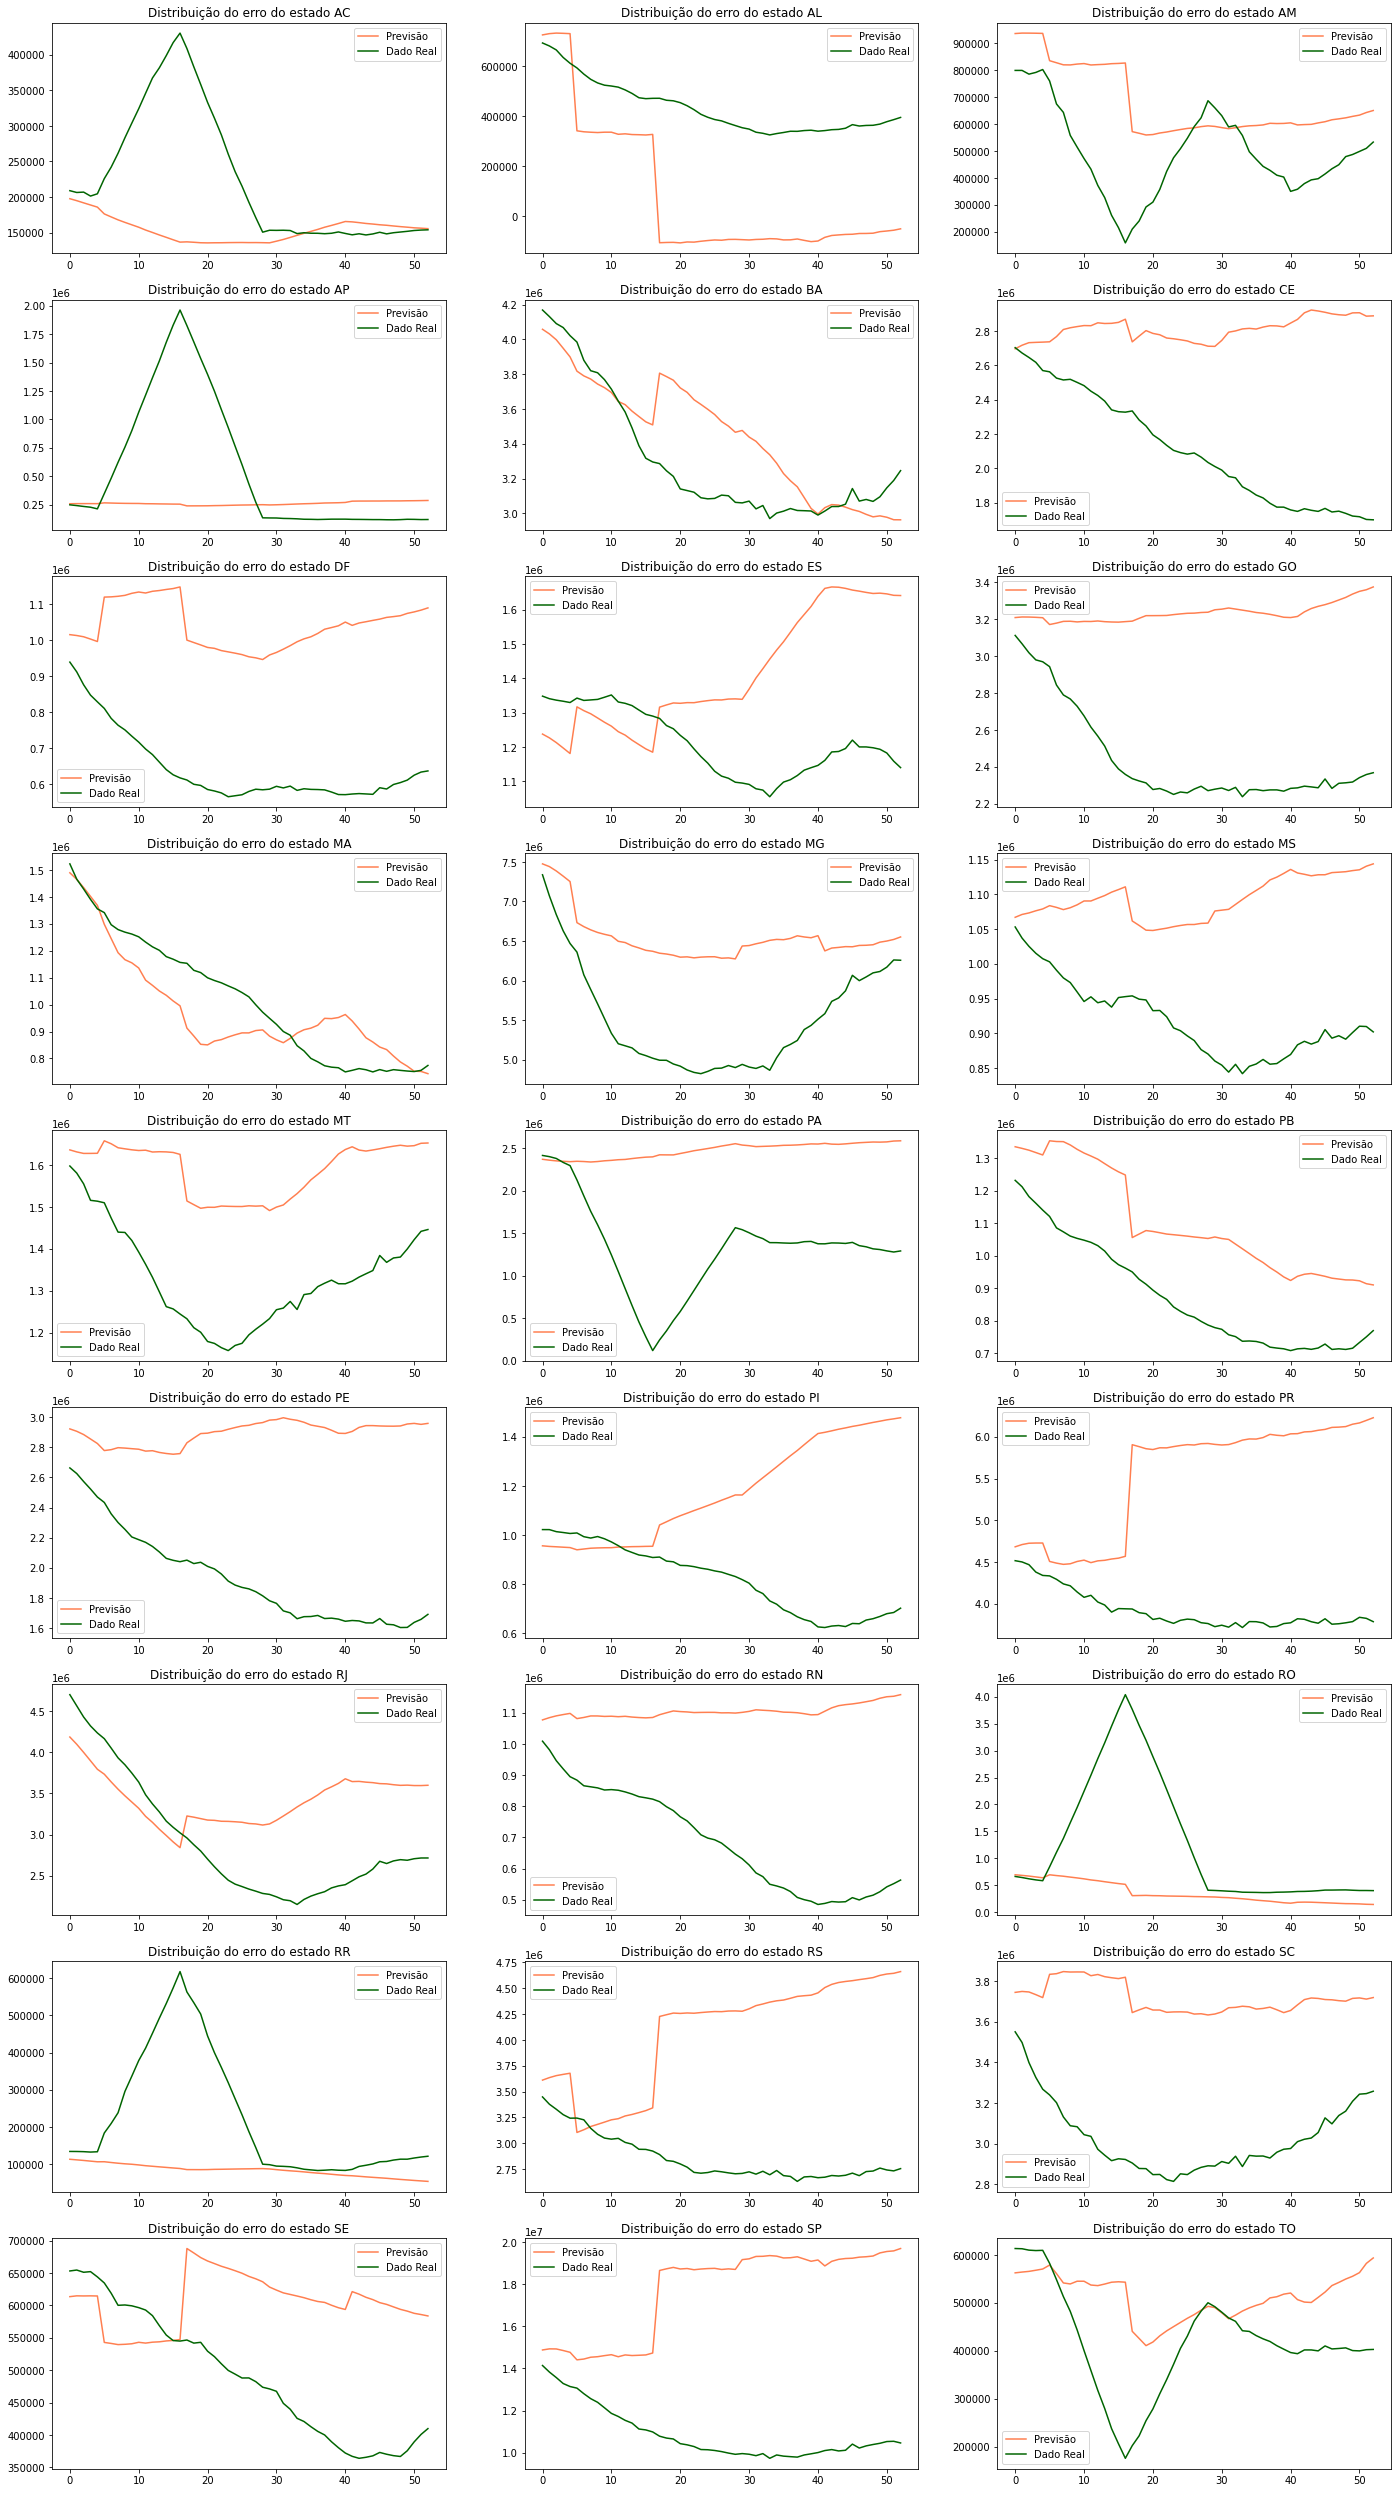

In [277]:
show_predictions_graphs(pred, y_test_states)

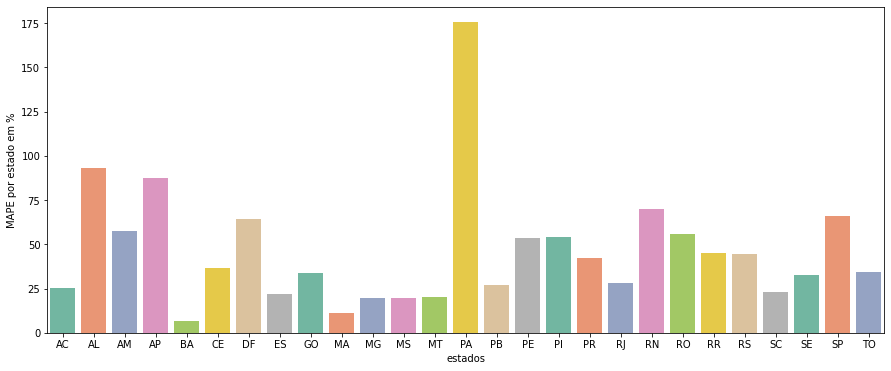

In [278]:
show_error_state(pred, y_test_states)

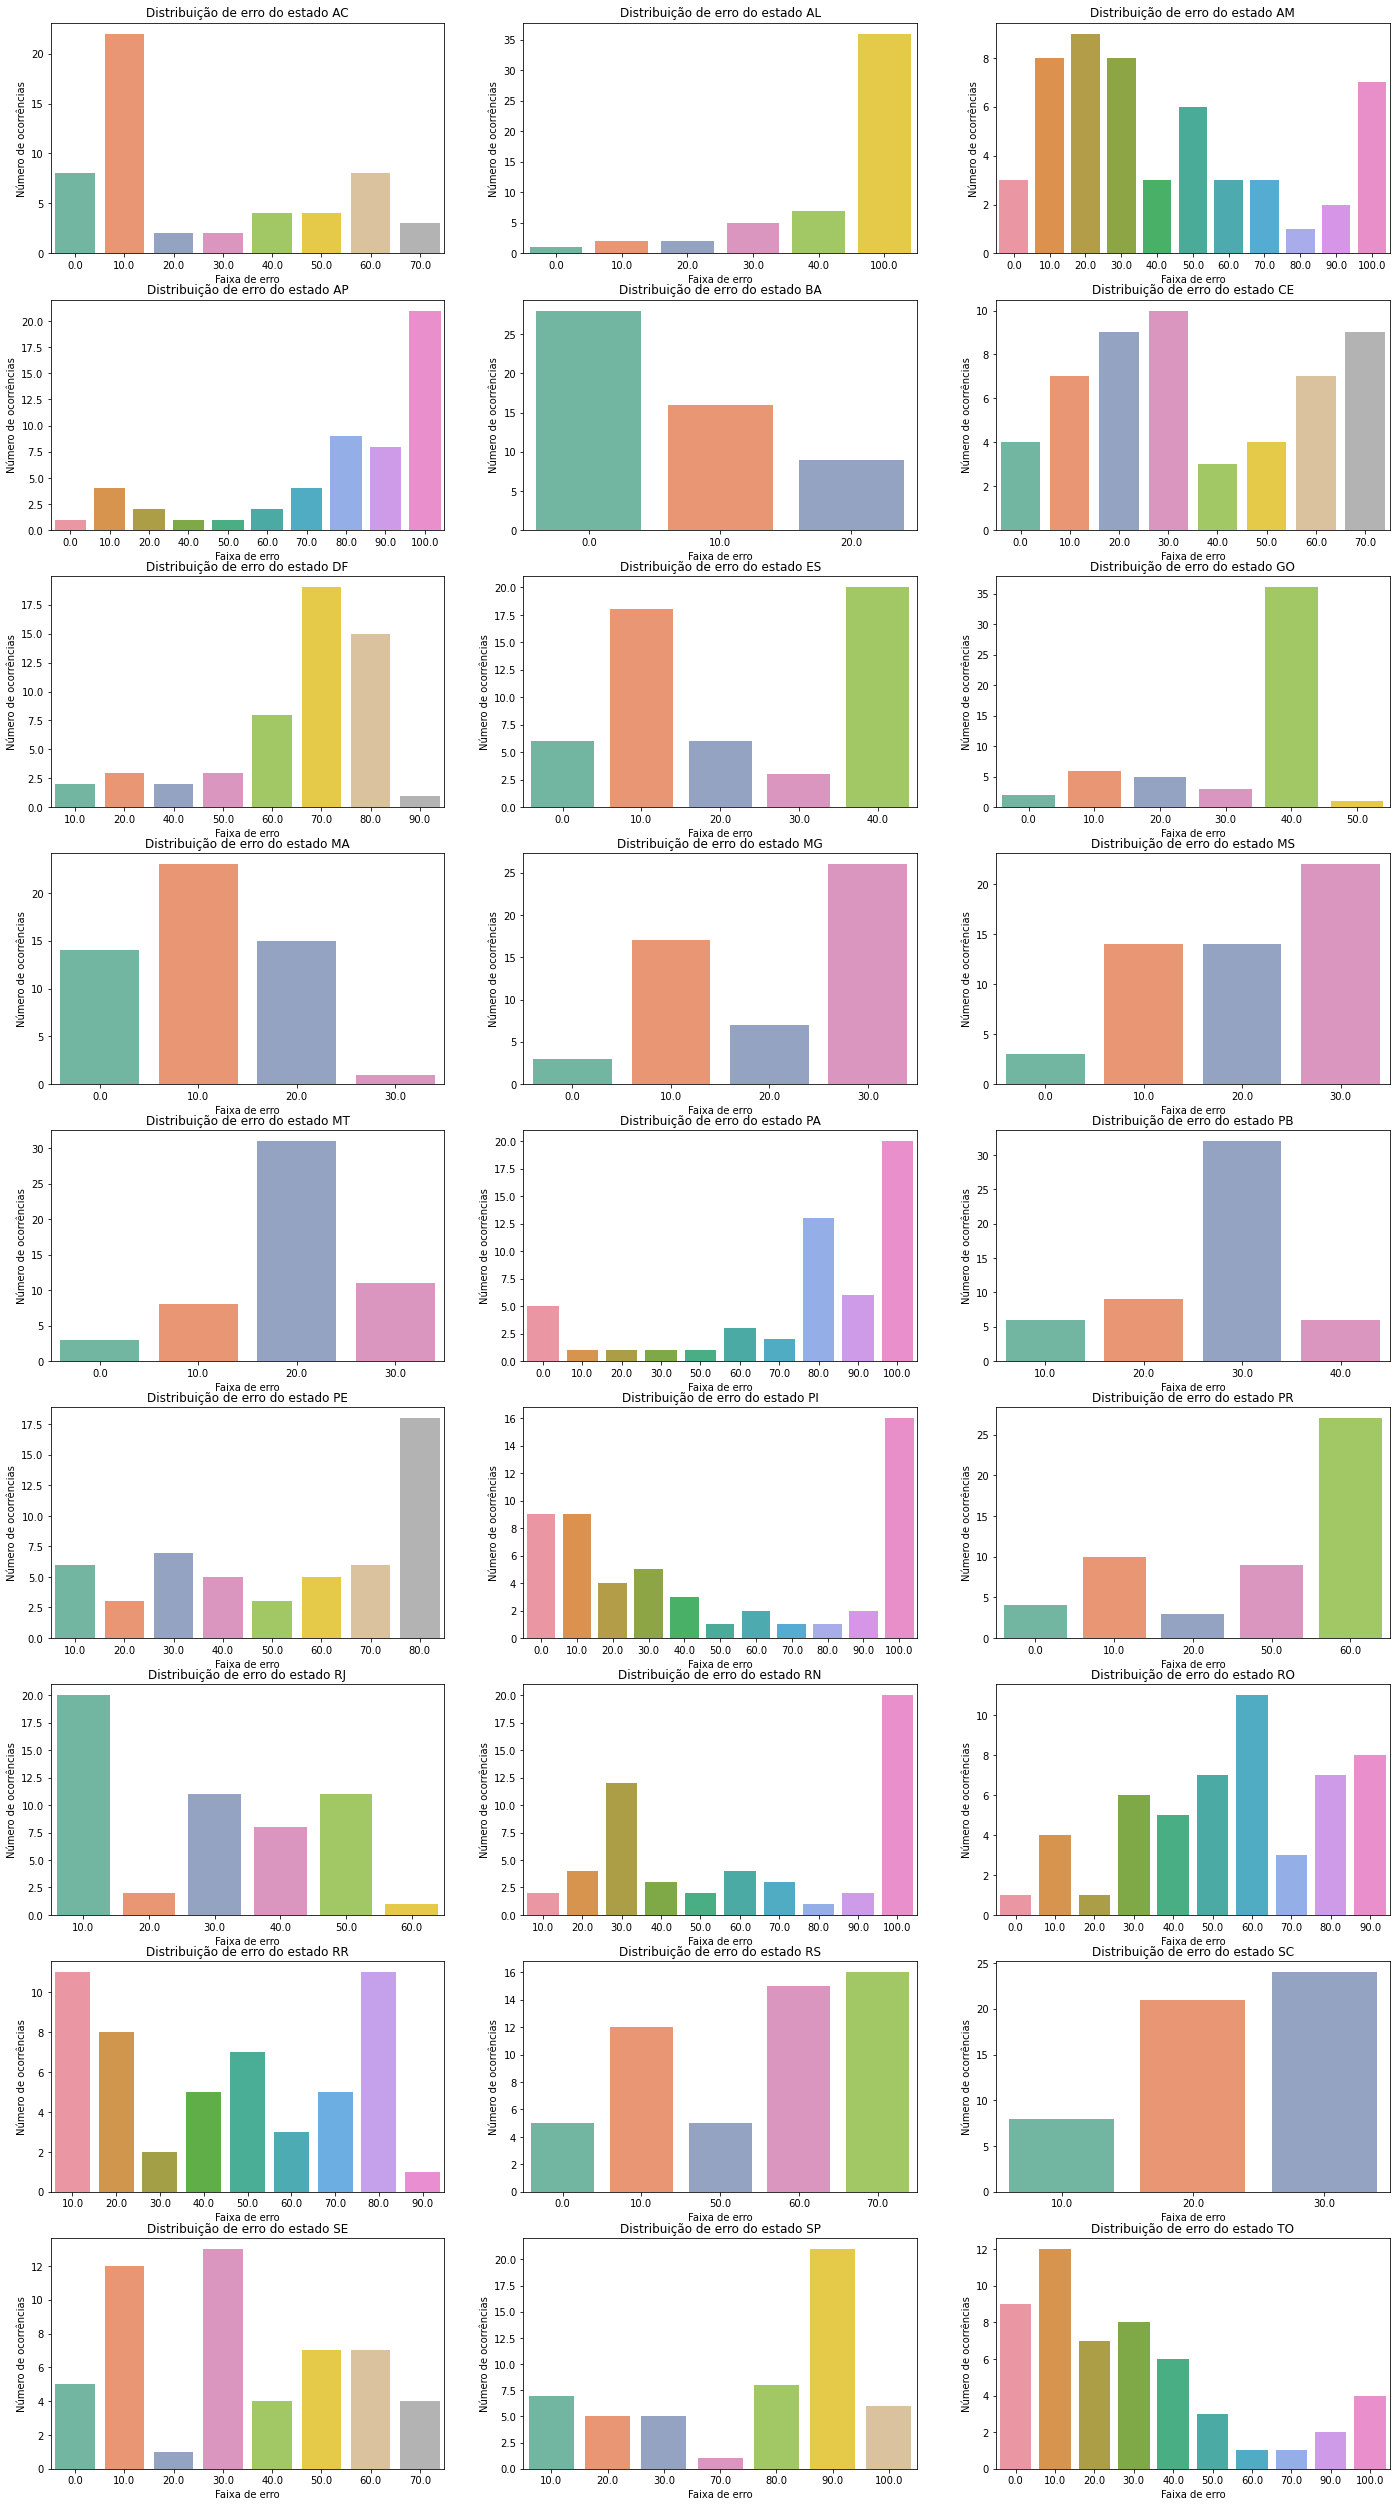

In [279]:
show_error_graphs(pred, y_test_states)

### Normalizaçõa com MinMax

In [280]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

In [281]:
pred = {}

y_test_states = {}

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    # normalizacao
    
    # calcula media e desvio padrao do treino e normaliza os dados
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[i] = regr.predict(x_test)

[AC]: Score: -0.7509925332507015
[AL]: Score: -14.056420215060493
[AM]: Score: -1.3828389653517656
[AP]: Score: -0.2908057688507988
[BA]: Score: 0.3692375855680027
[CE]: Score: -5.105414715079764
[DF]: Score: -16.722909879464872
[ES]: Score: -9.721461030454687
[GO]: Score: -9.974795658316808
[MA]: Score: 0.6690764163525984
[MG]: Score: -2.0018241720813563
[MS]: Score: -11.409307467112304
[MT]: Score: -4.669674154123271
[PA]: Score: -4.791578127023655
[PB]: Score: -1.0719848243626449
[PE]: Score: -10.41590672797222
[PI]: Score: -11.710130758837824
[PR]: Score: -64.94931343920751
[RJ]: Score: -0.2836127589164652
[RN]: Score: -6.987354769198908
[RO]: Score: -0.5043290398342941
[RR]: Score: -0.6622651141020854
[RS]: Score: -40.9522905731167
[SC]: Score: -15.313977817969022
[SE]: Score: -1.776665733449457
[SP]: Score: -38.094993419949276
[TO]: Score: -0.6921884344658245


#### Gráficos

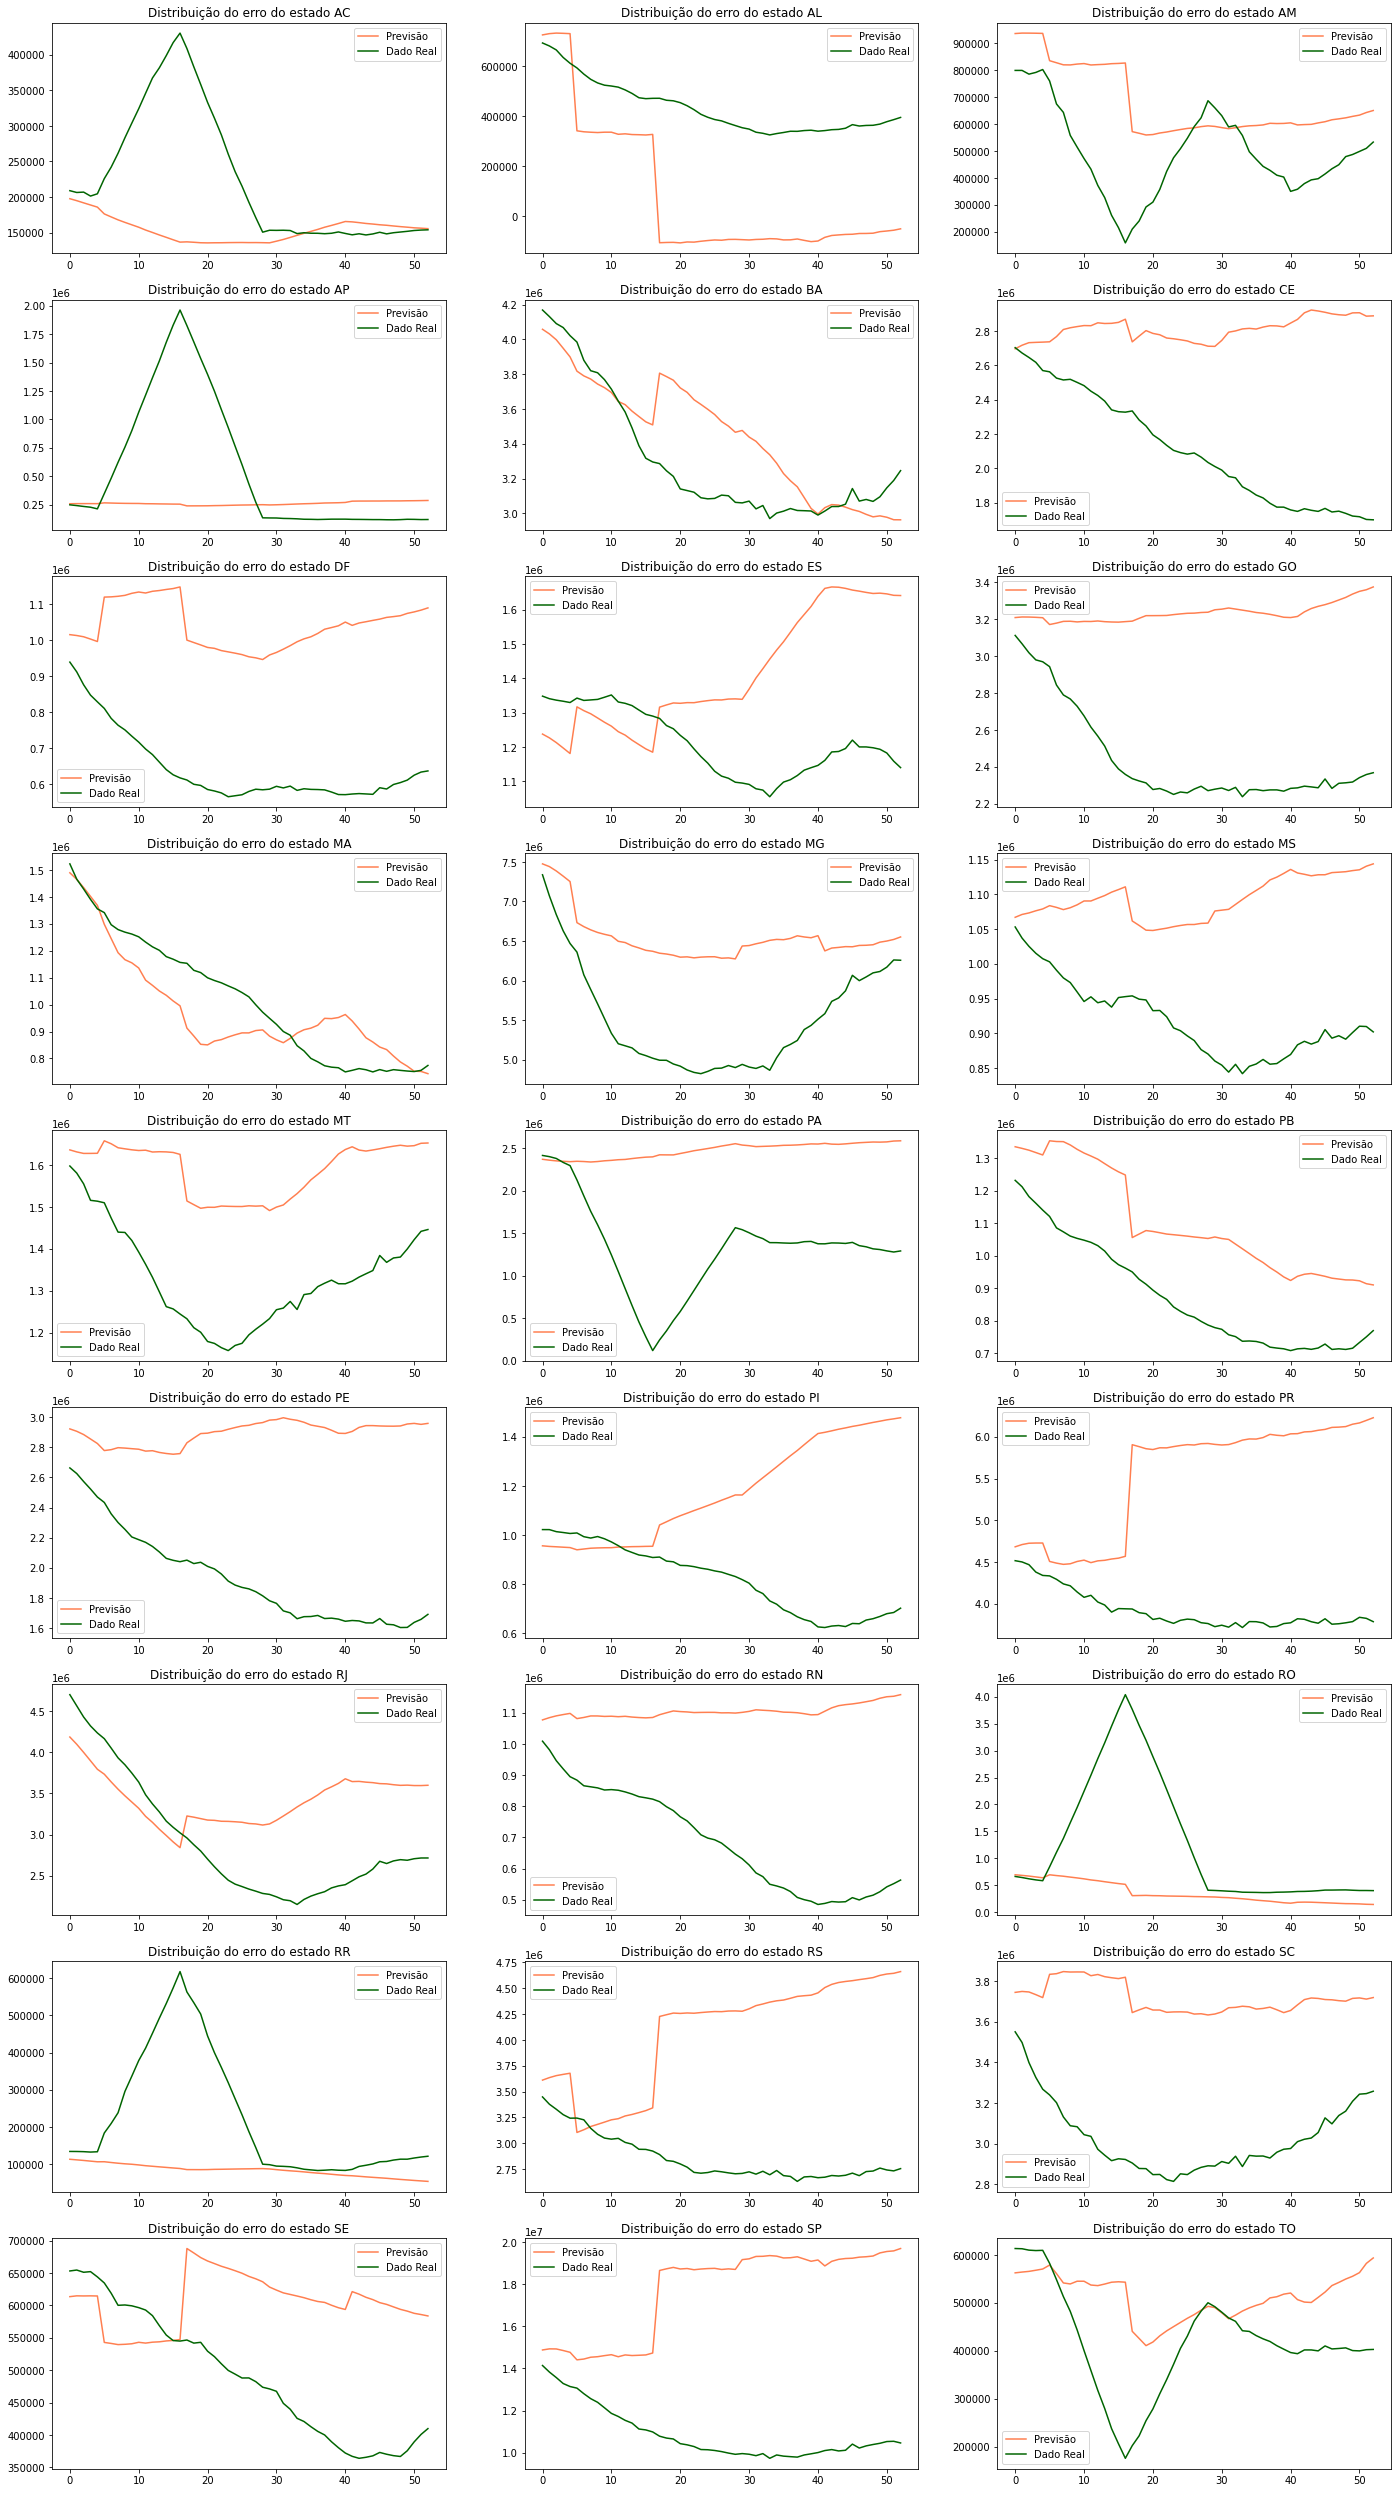

In [282]:
show_predictions_graphs(pred, y_test_states)

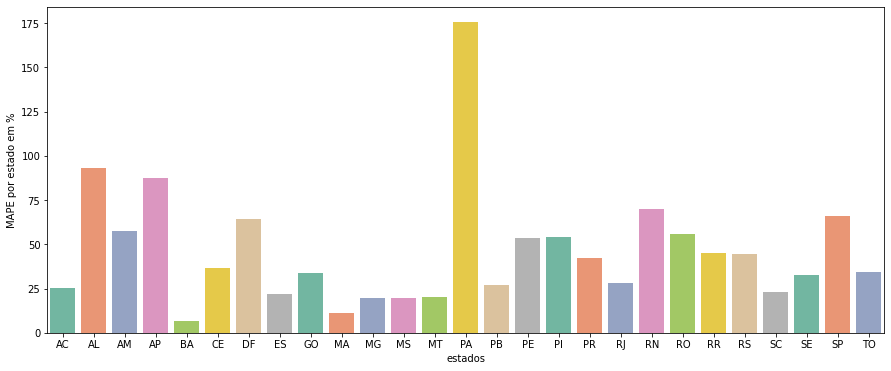

In [283]:
show_error_state(pred, y_test_states)


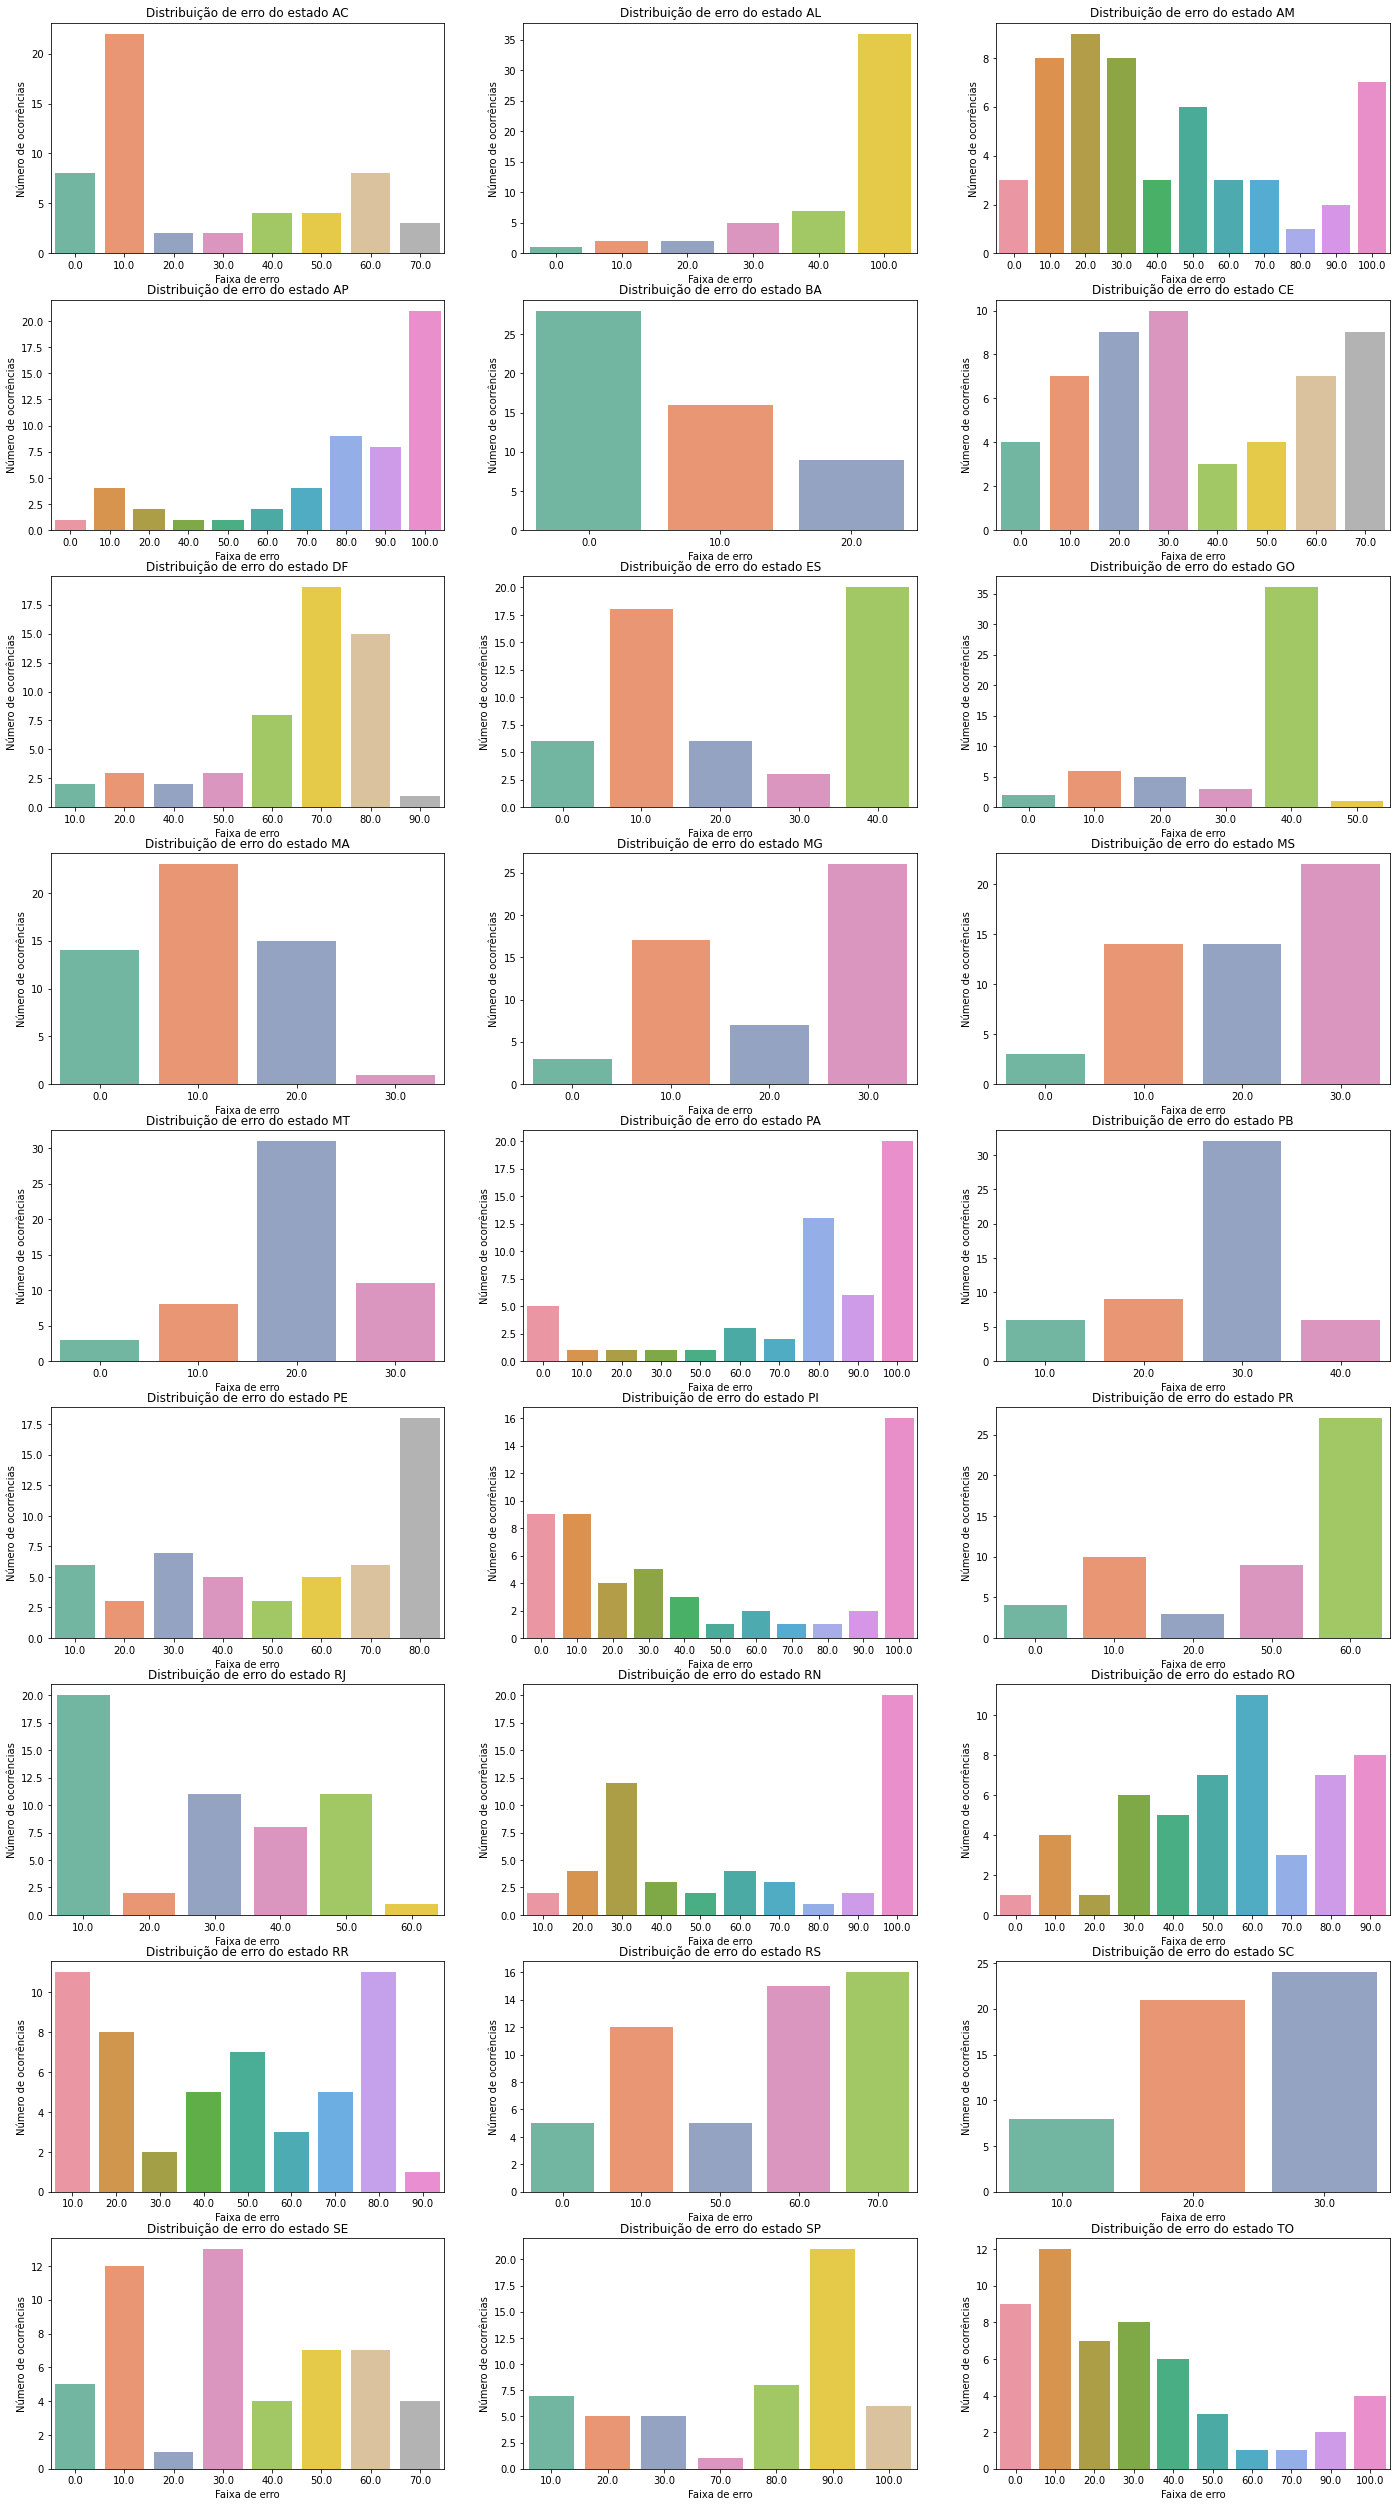

In [284]:
show_error_graphs(pred, y_test_states)

### Normalização com PowerTransform

In [285]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

In [286]:
pred = {}

y_test_states = {}

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    # normalizacao
    
    # calcula media e desvio padrao do treino e normaliza os dados
    scaler = PowerTransformer()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[i] = regr.predict(x_test)

[AC]: Score: 0.042222196604596696
[AL]: Score: 0.6373206148121184
[AM]: Score: -0.28040190503593654
[AP]: Score: -0.2958246583307216
[BA]: Score: 0.38291998770416835
[CE]: Score: -1.8563121146776171
[DF]: Score: -19.74652141506537
[ES]: Score: -2.690381421865628
[GO]: Score: -4.122114157378591
[MA]: Score: -4.454845238011663
[MG]: Score: 0.2548222670844066
[MS]: Score: 0.667068917734164
[MT]: Score: -4.928589651085225
[PA]: Score: -5.755276841560785
[PB]: Score: -0.9171811697737544
[PE]: Score: -1.754765219311583
[PI]: Score: -12.817772116586394
[PR]: Score: -13.004415456720578
[RJ]: Score: -8.728999778982475
[RN]: Score: -1.9423117993277144
[RO]: Score: -0.9624042407135662
[RR]: Score: -0.3994444032942206
[RS]: Score: -18.498502210176454
[SC]: Score: -0.08436874059917043
[SE]: Score: -2.3855865935998217
[SP]: Score: -13.009174215074212
[TO]: Score: -0.10385722482580739


#### Gráficos

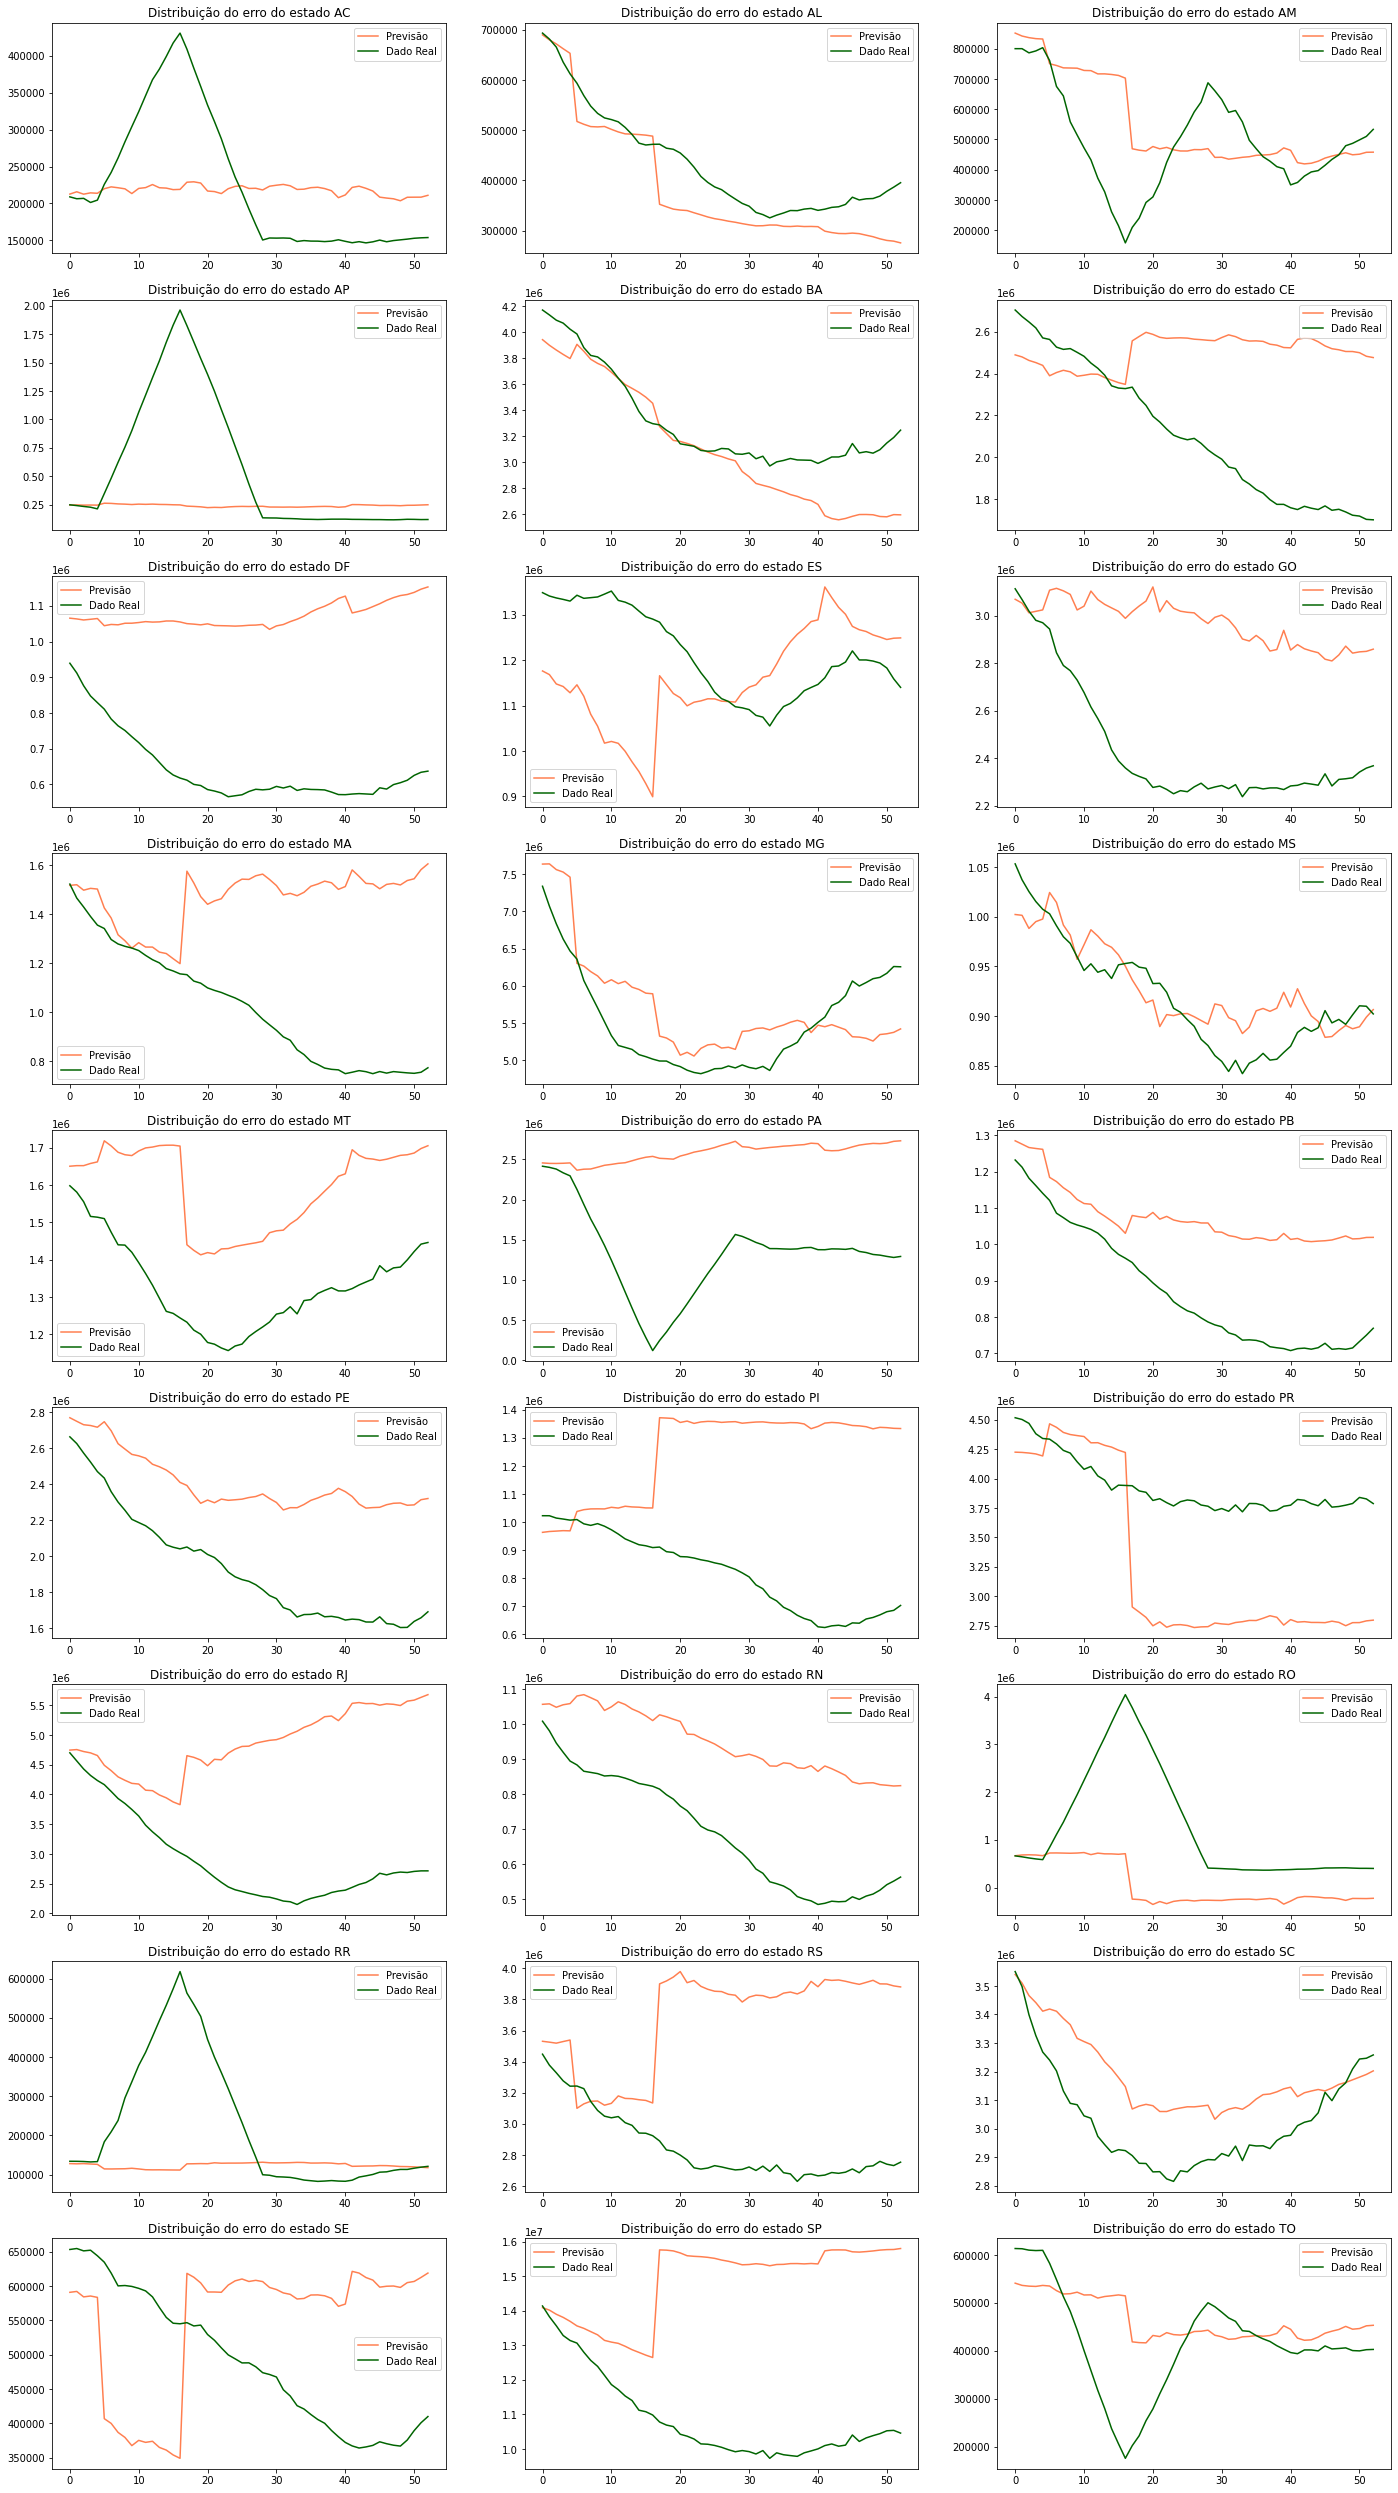

In [287]:
show_predictions_graphs(pred, y_test_states)

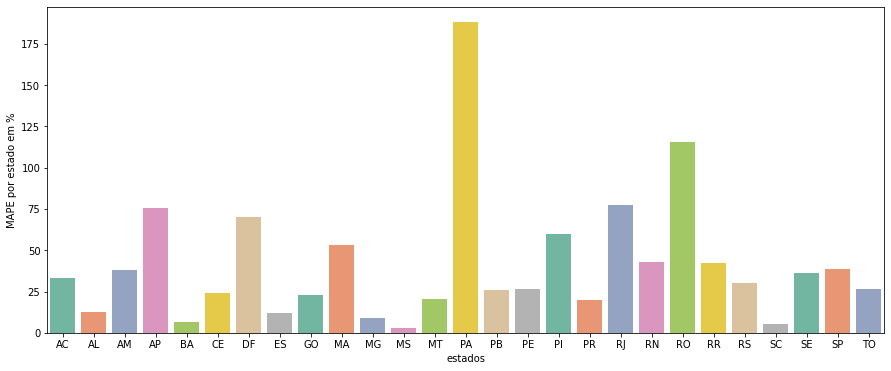

In [288]:
show_error_state(pred, y_test_states)


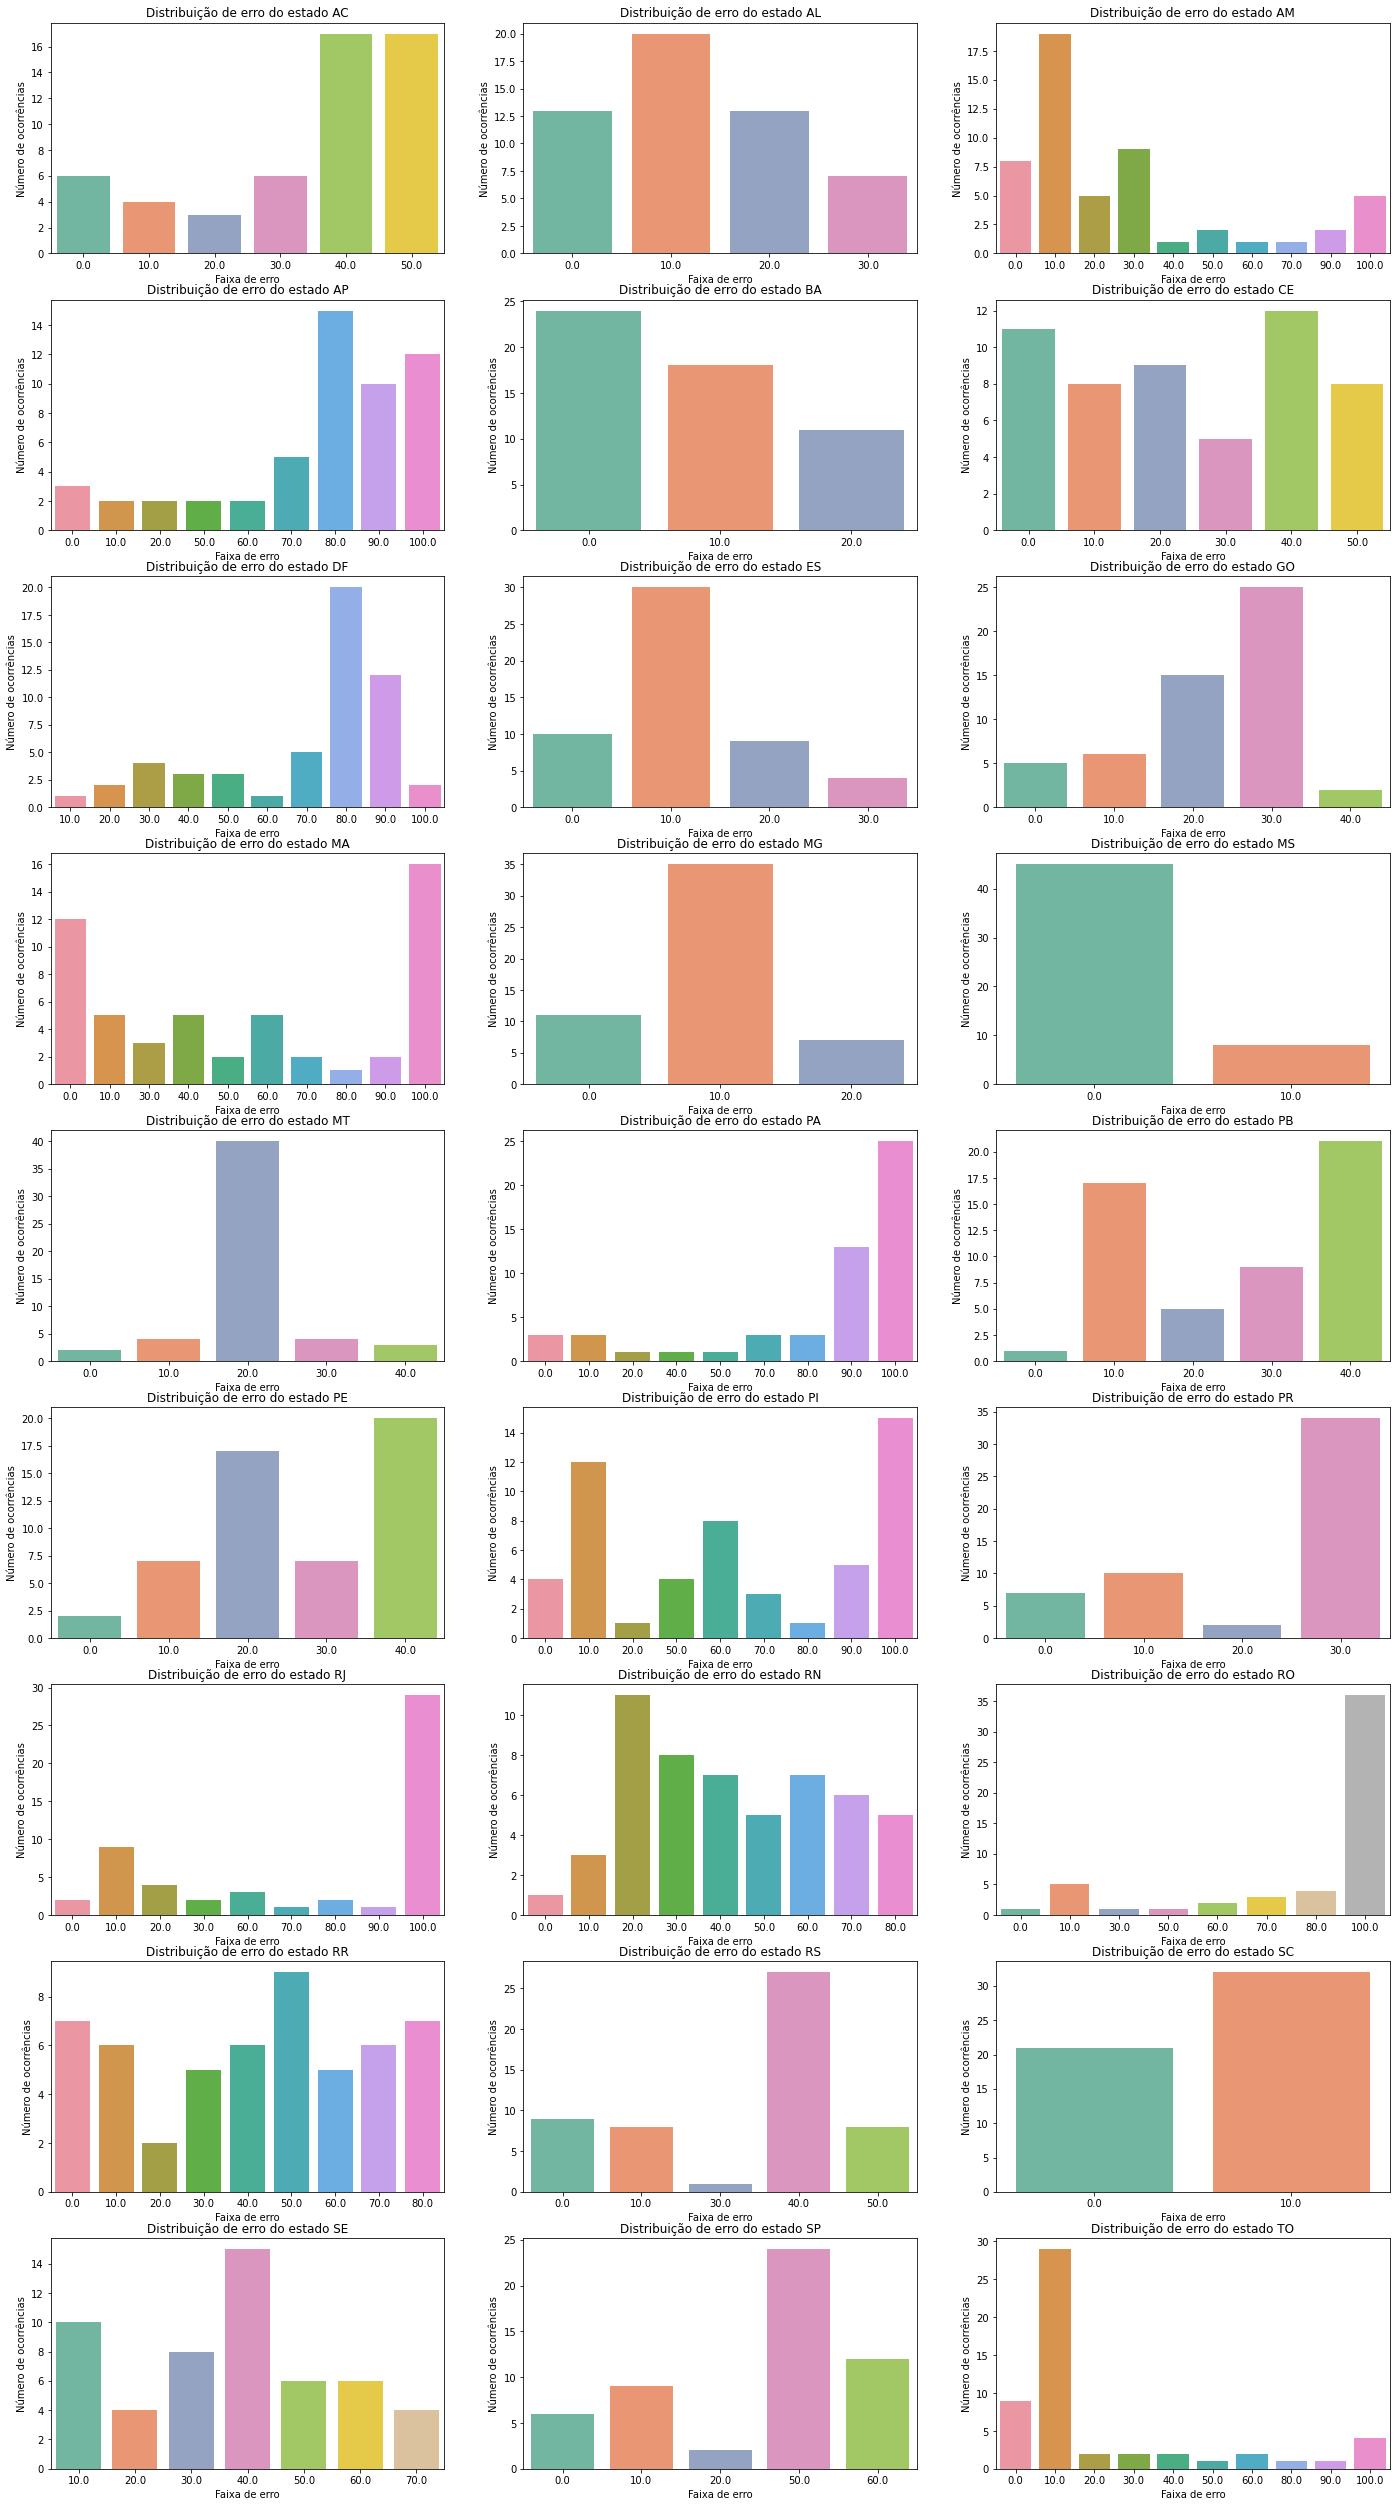

In [289]:
show_error_graphs(pred, y_test_states)